# Testing of NDI options relationship to ENSO driven atmospheric <br> response in comparison to Niño SST indices

In [1]:
'''
   Scott Meyer
   
   More in-depth tests of NDI options from 2 degrees of freedom
   search method. Use ERSST along with two other well known
   observational SST datasets, the COBE and HadISST, to help 
   determine if NDI options have a stronger relationship with
   different metrics of the atmospheric response to ENSO than 
   Niño SST indices.
'''

#For plotting figures below cell
%matplotlib inline 
#import rest of packages
import datetime as dt
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import csv as csv
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
import cartopy.io.shapereader as shpreader
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse

## Directory information for datasets

In [2]:
ENSOdir  = "C:\\Users\\Owner\\Documents\\python_dir\\ENSO_dir\\data_files\\"
ERSST    = ENSOdir + "ERSST\\sst.mnmean_updated.nc"
COBE     = ENSOdir + "COBE\\cobe_sst.mon.mean.nc"
HADISST  = ENSOdir + "HadISST\\HadISST_mon_mean.nc"
nclimdiv = ENSOdir + "nclimdiv\\"
GPCP     = ENSOdir + "GPCP\\precip.mon.mean_updated.nc"

### NetCDF file dump function

In [3]:
'''
   "ncdump" function to make .nc data information more readable

    Source: Chris Slocum
        http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html
'''

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.   
    
    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

### Class to make indexing latitude and longtide grid points simpler

In [4]:
''' 
    Recieved from Dr. John Nielsen-Gammon
    
    Define new class to extract gridded longitude and
    latitude indices for particular gridded, global 
    oceanic or atmospheric datasets using bounds of 
    the desired region. Accounts for differences
    in grid spacing among these datasets
    
    Input: Lat/Lon grid information
'''

class LatLon:
    def __init__(self,lat0=-90,dlat=1,nlat=181,lon0=0,dlon=1,nlon=360):
        self.lat0 = lat0
        self.dlat = dlat
        self.nlat = nlat
        self.lon0 = lon0
        self.dlon = dlon
        self.nlon = nlon
        
    def il(self,i):
        lati = self.lat0 + self.dlat*i
        return lati
    
    def jl(self,j,w=True):
        loni = self.lon0 + self.dlon*j
        if w and loni > 180:
            loni = -(360 - loni)
        return loni
    
    def li(self,latval):
        i = int(round((latval-self.lat0)/self.dlat))
        if i < 0:
            i += self.nlat
        if i >= self.nlat:
            i += -self.nlat  
        return i

    def lj(self,lonval):
        j = int(round((lonval-self.lon0)/self.dlon))
        if j < 0:
            j += self.nlon
        if j >= self.nlon:
            j += -self.nlon
        return j
    
    def lltoij(self,latval,lonval):
        i = self.li(latval)
        j = self.lj(lonval)
        return i,j
    
    def latr(self,latval1,latval2):
        i1 = self.li(latval1)
        i2 = self.li(latval2)
        ist = min(i1,i2)
        ien = ist + abs(i2-i1) + 1
        return ist,ien
    
    def lonr(self,lonval1,lonval2):
        j1 = self.lj(lonval1)
        j2 = self.lj(lonval2)
        jst = min(j1,j2)
        jen = jst + abs(j2-j1) + 1
        return jst,jen

## Load in SST data
### ERSST

In [5]:
ERSST_nc = Dataset(ERSST,'r')
nc_attrs,nc_dims,nc_vars = ncdump(ERSST_nc)

NetCDF Global Attributes:
	climatology: 'Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.'
	description: 'In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.'
	keywords_vocabulary: 'NASA Global Change Master Directory (GCMD) Science Keywords'
	keywords: 'Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >'
	instrument: 'Conventional thermometers'
	source_comment: 'SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker'
	geospatial_lon_min: -1.0
	geospatial_lon_max: 359.0
	geospatial_laty_max: 89.0
	geospatial_laty_min: -89.0
	geospatial_lat_max: 89.0
	geospatial_lat_min: -89.0
	geospatial_lat_units: 'degrees_north'
	geospatial_lon_units: 'degrees_east'
	cdm_data_type: 'Gr

In [6]:
ERSSTlats = ERSST_nc.variables['lat'][:]
ERSSTlons = ERSST_nc.variables['lon'][:] 
ERSSTtime = ERSST_nc.variables['time'][:]
ERSST = ERSST_nc.variables['sst'][:]  # shape is time, lat, lon
ERSSTdtime = num2date(ERSST_nc.variables['time'][:],ERSST_nc.variables['time'].units)
ERSSTnyears = ERSSTdtime[-1].year-ERSSTdtime[0].year

ERSSTll = LatLon(ERSSTlats[0],ERSSTlats[1]-ERSSTlats[0],
                 ERSST_nc.variables['lat'].size,
                 ERSSTlons[0],ERSSTlons[1]-ERSSTlons[0],
                 ERSST_nc.variables['lon'].size)

### COBE

In [7]:
COBE_nc = Dataset(COBE,'r') #reads in the data
nc_attrs,nc_dims,nc_vars = ncdump(COBE_nc)

NetCDF Global Attributes:
	title: 'COBE Sea Surface Temperature Analysis'
	history: 'created June 2011 at ESRL/PSD using the grib data from JRA.'
	platform: 'Analyses'
	original_source: 'http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_catalog?projectname=NEAR-GOOS'
	Conventions: 'CF-1.2'
	institution: 'NOAA ESRL/PSD'
	comment: 'recent values (w/i last year) may change as dataset is updated. It is a monitoring dataset.'
	dataset_title: 'COBE Sea Surface Temperature'
	References: 'https://www.psl.noaa.gov/data/gridded/data.cobe.html'
NetCDF dimension information:
	Name: lon
		size: 360
		type: dtype('float32')
		units: 'degrees_east'
		long_name: 'Longitude'
		actual_range: array([  0.5, 359.5], dtype=float32)
		axis: 'X'
		standard_name: 'longitude'
	Name: lat
		size: 180
		type: dtype('float32')
		units: 'degrees_north'
		long_name: 'Latitude'
		actual_range: array([ 89.5, -89.5], dtype=float32)
		axis: 'Y'
		standard_name: 'latitude'
	Name: time
		size: 1574
		type: dtype('float64

In [8]:
COBElats = COBE_nc.variables['lat'][:]
COBElons = COBE_nc.variables['lon'][:] 
COBEtime = COBE_nc.variables['time'][:]
COBESST = COBE_nc.variables['sst'][:]  # shape is time, lat, lon as shown above.
COBEdtime = num2date(COBE_nc.variables['time'][:],COBE_nc.variables['time'].units)
COBEnyears = COBEdtime[-1].year-COBEdtime[0].year

COBEll = LatLon(COBElats[0],COBElats[1]-COBElats[0],
                 COBE_nc.variables['lat'].size,
                 COBElons[0],COBElons[1]-COBElons[0],
                 COBE_nc.variables['lon'].size)

### HadISST

In [9]:

HADISST_nc = Dataset(HADISST,'r') #reads in the data
nc_attrs,nc_dims,nc_vars = ncdump(HADISST_nc)

NetCDF Global Attributes:
	Title: 'Monthly version of HadISST sea surface temperature component'
	description: 'HadISST 1.1 monthly average sea surface temperature'
	institution: 'Met Office Hadley Centre'
	source: 'HadISST'
	reference: 'Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., Kent, E. C., Kaplan, A.  Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century J. Geophys. Res.Vol. 108, No. D14, 4407 10.1029/2002JD002670'
	Conventions: 'CF-1.0'
	history: '9/2/2022 converted to netcdf from pp format'
	supplementary_information: 'Updates and supplementary information will be available from http://www.metoffice.gov.uk/hadobs/hadisst'
	comment: 'Data restrictions: for academic research use only. Data are Crown copyright see (http://www.opsi.gov.uk/advice/crown-copyright/copyright-guidance/index.htm)'
NetCDF dimension information:
	Name: time
		size: 1824
		type: dtype('float32')

In [10]:
''' Load in HadISST data variables'''
HADlats = HADISST_nc.variables['latitude'][:]  # extract/copy the data
HADlons = HADISST_nc.variables['longitude'][:] 
HADtime = HADISST_nc.variables['time'][:]
HADSST = HADISST_nc.variables['sst'][:]  # shape is time, lat, lon as shown above.
HADdtime = num2date(HADISST_nc.variables['time'][:],HADISST_nc.variables['time'].units)
HADnyears = HADdtime[-1].year-HADdtime[0].year

HADll = LatLon(HADlats[0],HADlats[1]-HADlats[0],
                 HADISST_nc.variables['latitude'].size,
                 HADlons[0],HADlons[1]-HADlons[0],
                 HADISST_nc.variables['longitude'].size)

## Outline important differences between SST datasets

### ERSST

In [11]:
print('\033[1m'+'Time range of available data'+'\033[0m')
print(ERSSTdtime[0].strftime('%m/%Y'),'to',ERSSTdtime[-1].strftime('%m/%Y'),'\n')

print('\033[1m'+'Latitude grid point information'+'\033[0m')
print('Range:',ERSSTlats[0],'to',ERSSTlats[-1])
print('Interval:',abs(ERSSTlats[1]-ERSSTlats[0]),'\n')

print('\033[1m'+'Longitude grid point information'+'\033[0m')
print('Range:',ERSSTlons[0],'to',ERSSTlons[-1])
print('Interval:',(ERSSTlons[1]-ERSSTlons[0]))

Time range of available data
01/1854 to 10/2021 

Latitude grid point information
Range: 88.0 to -88.0
Interval: 2.0 

Longitude grid point information
Range: 0.0 to 358.0
Interval: 2.0


### COBE

In [12]:
print('\033[1m'+'Time range of available data'+'\033[0m')
print(COBEdtime[0].strftime('%m/%Y'),'to',COBEdtime[-1].strftime('%m/%Y'),'\n')

print('\033[1m'+'Latitude grid point information'+'\033[0m')
print('Range:',COBElats[0],'to',COBElats[-1])
print('Interval:',abs(COBElats[1]-COBElats[0]),'\n')

print('\033[1m'+'Longitude grid point information'+'\033[0m')
print('Range:',COBElons[0],'to',COBElons[-1])
print('Interval:',(COBElons[1]-COBElons[0]))

Time range of available data
01/1891 to 02/2022 

Latitude grid point information
Range: 89.5 to -89.5
Interval: 1.0 

Longitude grid point information
Range: 0.5 to 359.5
Interval: 1.0


### HadISST

In [13]:
print('\033[1m'+'Time range of available data'+'\033[0m')
print(HADdtime[0].strftime('%m/%Y'),'to',HADdtime[-1].strftime('%m/%Y'),'\n')

print('\033[1m'+'Latitude grid point information'+'\033[0m')
print('Range:',HADlats[0],'to',HADlats[-1])
print('Interval:',abs(HADlats[1]-HADlats[0]),'\n')

print('\033[1m'+'Longitude grid point information'+'\033[0m')
print('Range:',HADlons[0],'to',HADlons[-1])
print('Interval:',(HADlons[1]-HADlons[0]))

Time range of available data
01/1870 to 12/2021 

Latitude grid point information
Range: 89.5 to -89.5
Interval: 1.0 

Longitude grid point information
Range: -179.5 to 179.5
Interval: 1.0


## Adjust SST datasets so they cover common <br> time period (01/1891-10/2021)

In [14]:
'''
   Use "SSTdtime_set" to set date range to be consistent
   across all SST datasets.
'''
#Use earliest start date of SST dataset (ERSST)
#and most recent end date of SST dataset (COBE)
SSTdtime_set = pd.date_range('1854-01-01', '2022-02-01', freq='MS')

beg_idx_ERSST = 0
beg_idx_HADSST = int(np.where(SSTdtime_set == '1870-01-01')[0])
beg_idx_COBE = int(np.where(SSTdtime_set == '1891-01-01')[0])

#idx for start date of datasets
s_idx_HADSST = beg_idx_COBE - beg_idx_HADSST
s_idx_ERSST = beg_idx_COBE
s_idx_COBE = 0

#idx for end date of datasets
end_idx_sst = int(np.where(SSTdtime_set == '2021-10-01')[0]) + 1

e_idx_ERSST = end_idx_sst
e_idx_HADSST = end_idx_sst - beg_idx_HADSST
e_idx_COBE = end_idx_sst - beg_idx_COBE

#set arrays to have same month range
ERSST = ERSST[s_idx_ERSST:e_idx_ERSST,:,:]
HADSST = HADSST[s_idx_HADSST:e_idx_HADSST,:,:]
COBE = COBESST[s_idx_COBE:e_idx_COBE,:,:]

print('Confirmation each SST dataset length matches','\n')
print('Month range of 3 SST datasets:',ERSST.shape[0],HADSST.shape[0],COBE.shape[0])

Confirmation each SST dataset length matches 

Month range of 3 SST datasets: 1570 1570 1570


In [15]:
'''
   Save COBE and HadISST data for use in
   different notebook
   
   Includes SST data, and lat/lon grid point
   information
'''
folder_names = ["COBE","HadISST"]
filenames = ["COBE_data_j1891_oct2021","HadISST_data_j1891_oct2021"]

COBE_file_path = ENSOdir + folder_names[0] + "\\" + filenames[0] + ".npz"
HAD_file_path = ENSOdir + folder_names[1] + "\\" + filenames[1] + ".npz"

np.savez(COBE_file_path,sst=COBE,lats=COBElats,lons=COBElons)
np.savez(HAD_file_path,sst=HADSST,lats=HADlats,lons=HADlons)

### New DateTime index for three SST arrays that span <br> the same monthly time period

In [16]:
SSTdtime = pd.date_range('1891-01-01', '2021-10-01', freq='MS')

## Calculate NDI options from 2 degrees of <br> freedom search with all three SST datasets

In [17]:
'''
   Final NDI options for testing using methods from thesis: 
   
   1. MC box: 0°,148°E-   30w by 18h
      EP box: 0°,145°W-   50w by 10h (mirrors the Niño 3.4 region)
   
   2. MC box: 0°,148°E-   30w by 18h (Same as NDI option 1)
      EP box: 2°S,150°W-  50w by 10h
      
   3. MC box: 2°N,156°E-  30w by 18h 
      EP box: 0°,150°W-   50w by 10h
   
   4. MC box: 2°N,156°E-  30w by 18h (Same as NDI option 3)
      EP box: 2°S,154°W-  42w by 10h
      
   5. MC box: 2°S,156°E-  10w by 10h
      EP box: 2°S,158°W-  42w by 10h
      
   6. MC box: 8°N,130°E-  10w by 10h     
      EP box: 0°S,145°W-  50w by 10h
      
   MC box option selected using northern hemisphere precipitation
   PC 1 eliminated due to weaker correlations than MC box options 
   for NDI options 1 and 2 and for correlations only exceeding 0.8
   for EP box options in DJF.
   
   Calculate correlations of each box with GPCP global PC 1 for 
   standard seasons. 
'''

season_names = ['MAM:','JJA:','SON:','DJF:']

'''
   Use different index strategies based on
   grid spacing. Both are centered grid points,
   but grid points are centered at .5 (1° spacing) 
   for COBE/HadISST while they are centered at 
   whole longitude numbers (2° spacing) for ERSST
'''

'''MC/EP lat,lon and 1/2 height info. for box retrieval'''
mclats = [0,0,2,2,-2,8]
mclons = [148,148,156,156,156,130]

eplats = [0,-2,0,-2,-2,0]
eplons = [-145,-150,-150,-154,-158,-145]

#For ERSST
ERSST_mch = [8,8,8,8,4,4]
ERSST_mcw = [14,14,14,14,4,4]

ERSST_eph = [4,4,4,4,4,4]
ERSST_epw = [24,24,24,20,20,24]

#For HADISST and COBE

#Make 1/2 heights slightly smaller than total
#half height to retrieve correct lat/lon indices
#for box calculations
HADCOBE_mch = [8.95,8.95,8.95,8.95,4.95,4.95]
HADCOBE_mcw = [14.95,14.95,14.95,14.95,4.95,4.95]

HADCOBE_eph = [4.95,4.95,4.95,4.95,4.95,4.95]
HADCOBE_epw = [24.95,24.95,24.95,20.95,20.95,24.95]

### Load in adjusted Niño 3.4 monthly SSTs for ERSST <br> NDI option 1 and 6 calculations

In [18]:
'''
   Load my monthly Niño 3.4 adjusted SST values that 
   match exact size of Niño 3.4 box from ERSST dataset
   to use in NDI option calculations.
'''

filename_nino3pt4monthly = ENSOdir + str("raw_nino_data\\nino3pt4monthly_j1854_oct2021.npy")
ERSST_nino34_full = np.load(filename_nino3pt4monthly)

#Trim the data to be same length as HadiSST and COBE
#using SSTdtime_set
s_ind_trim = int(np.where(SSTdtime_set == '1891-01-01')[0])
ERSST_nino34 = ERSST_nino34_full[s_ind_trim:]

### Calculate monthly NDI values

In [19]:
'''
   Calculate NDI options for all SST datasets
   for full length of the dataset 
   (Jan. 1891- Oct. 2021)
'''
#already made all 3 datasets match in temporal length
sst_month_count = ERSST.shape[0]

NDI_opts_monthly = np.zeros((3,6,sst_month_count))
for sst_type in range(3):
    #can use same mch/mcw for COBE/HadISST
    #since they have same grid centers and
    #spacing
    if sst_type == 0:
        mch = ERSST_mch
        mcw = ERSST_mcw
        
        eph = ERSST_eph
        epw = ERSST_epw
    else:
        mch = HADCOBE_mch
        mcw = HADCOBE_mcw
    
    if sst_type == 0:
        SST = ERSST
    elif sst_type == 1:
        SST = COBE
    elif sst_type == 2:
        SST = HADSST
        
    for options in range(6):
        '''MC box calcuations'''
        mc_north = mclats[options] + mch[options]
        mc_south = mclats[options] - mch[options]
    
        mc_east = mclons[options] + mcw[options]
        mc_west = mclons[options] - mcw[options]
        
        #must use HadiSST lat/lon object since longitude
        #data starts at the dateline, different than COBE
        if sst_type == 0:
            mc_latr = ERSSTll.latr(mc_north,mc_south)
            mc_lonr = ERSSTll.lonr(mc_east,mc_west)
        elif sst_type == 1:
            mc_latr = COBEll.latr(mc_north,mc_south)
            mc_lonr = COBEll.lonr(mc_east,mc_west)
        else:
            mc_latr = HADll.latr(mc_north,mc_south)
            mc_lonr = HADll.lonr(mc_east,mc_west)
            
        mc_box = np.zeros(sst_month_count,)
        for months in range(sst_month_count):
            mc_box[months] = np.mean(SST[months,mc_latr[0]:mc_latr[1],
                                         mc_lonr[0]:mc_lonr[1]])
    
        '''EP box calculations'''
        ep_north = eplats[options] + eph[options]
        ep_south = eplats[options] - eph[options]
        
        ep_east = eplons[options] + epw[options]
        ep_west = eplons[options] - epw[options]
        
        if sst_type == 0:
            ep_latr = ERSSTll.latr(ep_north,ep_south)
            ep_lonr = ERSSTll.lonr(ep_east,ep_west)
        elif sst_type == 1:
            ep_latr = COBEll.latr(ep_north,ep_south)
            ep_lonr = COBEll.lonr(ep_east,ep_west)
        else:
            ep_latr = HADll.latr(ep_north,ep_south)
            ep_lonr = HADll.lonr(ep_east,ep_west)
            
        #use adjusted ERSST Niño 3.4 SST box
        #for NDI option 1 and 6 using ERSST data
        if sst_type == 0 and options == 0 or sst_type == 0 and options == 5:
            ep_box = ERSST_nino34
        else:
            ep_box = np.zeros(sst_month_count)
            for months in range(sst_month_count):
                ep_box[months] = np.mean(SST[months,ep_latr[0]:ep_latr[1],
                                             ep_lonr[0]:ep_lonr[1]])
        '''NDI calculations'''
        for months in range(sst_month_count):
            NDI_opts_monthly[sst_type,options,months] = ep_box[months] - mc_box[months]

### Calculate standard season index values of NDI options for tests
### MAM 1891-DJF 2021

In [20]:
'''
   **Standard season definitions**
   
   Average of index values for:
   
   MAM = March, April, May (Northern hemisphere Spring)
   JJA = June, July, August (Summer)
   SON = September, October, November (Fall)
   DJF = December, January, February (Winter)
'''
year_count_sst = SSTdtime[-1].year - SSTdtime[0].year
#SST types (3), NDI options (6), seasons (4), Common year count for all SST datasets (130)
NDI_opts_seasons = np.zeros((3,6,4,year_count_sst))

for sst_type in range(3):
    for option in range(6):
        for season in range(4):
            for year in range(year_count_sst):
                #First calculation: MAM 1891
                month_idx = 2 + year*12 + 3*season
                NDI_opts_seasons[sst_type,option,season,year] = np.mean(NDI_opts_monthly[sst_type,option,
                                                                                         month_idx:month_idx+3])

### Calculate one month standard season lead of NDI options for tests
### FMA 1891-NDJ 2021

In [21]:
'''
   Same as above except for shifting the average
   period back one month
   
   For example, instead of MAM I calculate February,
   March, April (FMA) here
'''

NDI_opts_seasons_lead = np.zeros((3,6,4,year_count_sst))

for sst_type in range(3):
    for option in range(6):
        for season in range(4):
            for year in range(year_count_sst):
                #First calculation: FMA 1891
                month_idx = 1 + year*12 + 3*season
                NDI_opts_seasons_lead[sst_type,option,season,year] = np.mean(NDI_opts_monthly[sst_type,option,
                                                                                              month_idx:month_idx+3])

## Calculate Oceanic Niño Index (ONI) and Niño 3 index with <br> COBE and HadISST data for accurate comparisons with <br> NDI options using each SST dataset

In [22]:
'''
   Calculate Niño 3.4 SST box for COBE and HadISST and
   compare with my adjusted box using ERSST. 
   
   COBE and HadISST grid points and spacing allow for 
   exact indexing of Niño boxes.
'''

#box center + dimension information for
#Niño 3 and Niño 3.4 box for calculation
#of Niño 3 index and ONI
ninobox_lat = [0,0]
ninobox_lon = [-145,-120]

ninobox_h = [4.95,4.95]
ninobox_width = [24.95,29.95]


COBEHAD_nino34 = np.zeros((2,sst_month_count))
COBEHAD_nino3 = np.zeros((2,sst_month_count))
for idx in range(2):
    ninobox_n = ninobox_lat[idx] + ninobox_h[idx]
    ninobox_s = ninobox_lat[idx] - ninobox_h[idx]
    
    ninobox_w = ninobox_lon[idx] - ninobox_width[idx]
    ninobox_e = ninobox_lon[idx] + ninobox_width[idx]
    
    for sst_type in range(2):
        if sst_type == 0:
            SST = COBE
            latr = COBEll.latr(ninobox_n,ninobox_s)
            lonr = COBEll.lonr(ninobox_e,ninobox_w)
        else:
            SST = HADSST
            latr = HADll.latr(ninobox_n,ninobox_s)
            lonr = HADll.lonr(ninobox_e,ninobox_w)
        if idx == 0:
            for months in range(sst_month_count):
                nino34 = SST[months,latr[0]:latr[1],lonr[0]:lonr[1]]
                COBEHAD_nino34[sst_type,months] = np.nanmean(nino34)
        else:
            for months in range(sst_month_count):
                nino3 = SST[months,latr[0]:latr[1],lonr[0]:lonr[1]]
                COBEHAD_nino3[sst_type,months] = np.nanmean(nino3)

### Confirmation I need to calculate Niño SST indices <br> for COBE and HadISST

In [23]:
'''
   Correlation of monthly ERSST Niño 3.4 SST box with HadISST and COBE
   
   For full length of available data
'''
print('\033[1m'+'Correlations with ERSST Niño 3.4 monthly'+'\033[0m'+'\n')

sst_type = ['COBE:','HadISST:']
print('Time period: 1891-2021')
for i in range(2):
    print(sst_type[i],np.round(np.corrcoef(ERSST_nino34,COBEHAD_nino34[i,:])[0,1],3))
    
print('\n',end='')

'''For more reliable data (post WW-II data)'''
syear_test = 1950
syear_sst = 1891
s_ind_test = syear_test - syear_sst
          
print('Time period: 1950-2021')
for i in range(2):
    print(sst_type[i],np.round(np.corrcoef(ERSST_nino34[s_ind_test:],COBEHAD_nino34[i,s_ind_test:])[0,1],3))

Correlations with ERSST Niño 3.4 monthly

Time period: 1891-2021
COBE: 0.947
HadISST: 0.926

Time period: 1950-2021
COBE: 0.948
HadISST: 0.924


### Process to calculate Niño SST indices with COBE and HadISST

In [24]:
'''
   Transform COBEHAD Niño 3 and Niño 3.4 into year/month arrays (2-d)
'''
yr_len_sst = SSTdtime[-1].year - SSTdtime[0].year

#Add one to yr_len_sst to import all years and
#end of dataset up to 10/2021. Leave nan's for 
#no values (11/2021 and 12/2021)
COBEHAD_nino34_ym = np.zeros((2,yr_len_sst+1,12))
COBEHAD_nino3_ym = np.zeros((2,yr_len_sst+1,12))

COBEHAD_nino34_ym[:,:yr_len_sst,:] = COBEHAD_nino34[:,:-10].reshape(2,yr_len_sst,12)
COBEHAD_nino34_ym[:,-1,:10] = COBEHAD_nino34[:,-10:].reshape(2,10)
COBEHAD_nino34_ym[:,-1,10:] = np.nan

COBEHAD_nino3_ym[:,:yr_len_sst,:] = COBEHAD_nino3[:,:-10].reshape(2,yr_len_sst,12)
COBEHAD_nino3_ym[:,-1,:10] = COBEHAD_nino3[:,-10:].reshape(2,10)
COBEHAD_nino3_ym[:,-1,10:] = np.nan

In [25]:
'''
   Calculate the Niño 3 index and ONI with COBE and 
   HadISST for consistency with data.
   
   Follows same procedure as in ENSO_index_recreation
   jupyter notebook.
'''

#number of thiry year periods, since each period starts at 5 year inc.
thirty_yr_period_count = np.arange(1891,1991,5).shape[0] + 1 

#Find start year idx for 30 year mean calculations, 
#which is start year for 30 year averages minus start year ersst data
yr_start_30yr_means_idx = int(np.where(SSTdtime == '1891-01-01')[0]/12)

#find month/year index value for full SST data set that corresponds to beginning of 1991
SST_ind_1991_monthly = np.where(SSTdtime == '1991-01-01')[0]
yr_start_for_final_30yr_mean_idx = int(SST_ind_1991_monthly/12)


#empty array used in for loop
COBEHAD_nino3_30yr_means = np.zeros((2,thirty_yr_period_count,12))
COBEHAD_nino34_30yr_means = np.zeros((2,thirty_yr_period_count,12))

#array for Niño means (monthly) will be thirty year mean calc number 
#[0,:] = 1891 to 1920 mean. [1,:] = 1896 to 1925 mean,....
#first for loop shifts indexing every 5 years up to 1991avg
#Indexes every 5 yrs.
for idx in range(2):
    if idx == 0:
        nino_monthly_ym = COBEHAD_nino3_ym
    else:
        nino_monthly_ym = COBEHAD_nino34_ym
    for sst_type in range(2):
        for count in range(yr_start_30yr_means_idx,yr_start_for_final_30yr_mean_idx+5,5):
            #idx to store 30 year means for each month
            idx_store = int(np.round(count/5,0))
            for month in range(12):
                if idx == 0:
                    COBEHAD_nino3_30yr_means[sst_type,idx_store,month] = np.mean(nino_monthly_ym[idx,count:count+30,month])
                else:
                    COBEHAD_nino34_30yr_means[sst_type,idx_store,month] = np.mean(nino_monthly_ym[idx,count:count+30,month])   

In [26]:
'''
   Calculate SST monthly anomaly values for Niño 3
   and 3.4 box. Data calculations start at 01/1906
   and end at 10/2021.
   
   Have to begin calculations in 1906 because 
   the start time of overlapping data is in 1891.
   The 5 year period that uses the first available
   30 year mean of 1891-1920 as climatology to 
   calculate anomalies is 1906-1910.
   
   Note:
   Mean becomes non-centered after the period of
   2006-2010, which uses 1991-2020 mean.
   Period of 2011-2021 forced to use non-centered 
   mean.
'''

#want data calculations to start at 01/1891
SST_ind_1906_monthly = np.where(SSTdtime == '1906-01-01') 
start_year_ind = int(SST_ind_1906_monthly[0]/12) 

#Index last year period to use centered averages before 
#switching to using 1991-2010 mean for rest of values
#(non-centered averages)
SST_ind_2006_monthly = np.where(SSTdtime == '2006-01-01')
ind_non_centered_avgs = int(SST_ind_2006_monthly[0]/12)

yr_len_array = yr_len_sst+1-start_year_ind
#arrays for storing calculations in for loop
COBEHAD_nino3monthly_anom = np.zeros((2,yr_len_array,12))
COBEHAD_nino34monthly_anom = np.zeros((2,yr_len_array,12))

'''
   Calculate monthly anomalies for each Niño box using
   centered thirty year means for each 5 year period. 
'''

'''For time period of 1906-2020'''
for idx in range(2):
    if idx == 0:
        nino_monthly_ym = COBEHAD_nino3_ym
        nino_30yr_means = COBEHAD_nino3_30yr_means
    else:
        nino_monthly_ym = COBEHAD_nino34_ym
        nino_30yr_means = COBEHAD_nino34_30yr_means
    
    for sst_type in range(2):
        #sst_type "0" index for each nino box array is COBE,
        #"1" = HadISST
        if sst_type == 0:
            nino_monthly_ym_loop = nino_monthly_ym[0,:,:]
            nino_30yr_means_loop = nino_30yr_means[0,:,:]
        else:
            nino_monthly_ym_loop = nino_monthly_ym[1,:,:]
            nino_30yr_means_loop = nino_30yr_means[1,:,:]
            
        nino_monthly_anom = np.zeros((yr_len_sst-start_year_ind,12))
        for year in range(start_year_ind,yr_len_sst,5):
            #indexing proper mean to subtract for anomaly values
            loop_count = int(np.round(year/5)) - 3
            mean_idx = loop_count 
            #for monthly anomaly array storage
            array_ind = year - start_year_ind
            for month in range(12):
                if year < ind_non_centered_avgs:
                    nino_monthly_anom[array_ind:array_ind+5,
                                      month] = nino_monthly_ym_loop[year:year+5,month] - nino_30yr_means_loop[mean_idx,month]
                elif year >= ind_non_centered_avgs:
                    nino_monthly_anom[array_ind:array_ind+5,
                                      month] = nino_monthly_ym_loop[year:year+5,month] - nino_30yr_means_loop[-1,month]
                
        if idx == 0:
            COBEHAD_nino3monthly_anom[sst_type,:-1,:] = nino_monthly_anom
        else:
            COBEHAD_nino34monthly_anom[sst_type,:-1,:] = nino_monthly_anom
                        
'''For 2021 SST data'''
nino3_anom = COBEHAD_nino3_ym[:,-1,:] - COBEHAD_nino3_30yr_means[:,-1,:]
nino34_anom = COBEHAD_nino34_ym[:,-1,:] - COBEHAD_nino34_30yr_means[:,-1,:]

COBEHAD_nino3monthly_anom[:,-1,:] = nino3_anom
COBEHAD_nino34monthly_anom[:,-1,:] = nino34_anom

In [27]:
'''Calculate ONI and Niño 3 index values.
   Since I can only have available data
   starting at 1906 for both datasets,
   I begin calculations for January 1910
   index value  (DJF 1910).
   
   Note: ONI uses 3 month rolling means
         of anomalies while the Nino 3 index
         uses 5 month rolling means of
         anomalies for index values.
   
   DJF 1910   ONI
   NDJFM 1910 Nino 3 index
'''
COBEHAD_nino3_anom_vec = COBEHAD_nino3monthly_anom.reshape(2,yr_len_array*12)
COBEHAD_nino34_anom_vec = COBEHAD_nino34monthly_anom.reshape(2,yr_len_array*12)

s_ind_anom = int(np.where(SSTdtime == '1906-01-01')[0])
s_ind_calcs = int(np.where(SSTdtime == '1910-01-01')[0])
e_ind_calcs = int(np.where(SSTdtime == '2021-02-01')[0]) + 1
s_idx = s_ind_calcs - s_ind_anom
e_idx = e_ind_calcs - s_ind_anom
        
COBEHAD_nino3idx = np.zeros((2,e_idx-s_idx))
for sst_type in range(2):
    for months in range(s_idx,e_idx):
        month_idx = months - s_idx
        COBEHAD_nino3idx[sst_type,month_idx] = np.mean(COBEHAD_nino3_anom_vec[sst_type,months-2:months+3])
        
COBEHAD_oni = np.zeros((2,e_idx-s_idx))
for sst_type in range(2):
    for months in range(s_idx,e_idx):
        month_idx = months - s_idx
        COBEHAD_oni[sst_type,month_idx] = np.mean(COBEHAD_nino34_anom_vec[sst_type,months-1:months+2])

## Comparison of ONI and Niño 3 index for SST datasets

In [28]:
'''Load in my calculated ERSST ONI and Niño 3 index data'''

dir_path_indices = ENSOdir + str("\\ENSO_indices")
filename_indices_oni = dir_path_indices + str("\\oni_ersst_j1892_f2021.npy")

ERSST_oni = np.load(filename_indices_oni)
#remove empty values (March-December 2021 index values)
ERSST_oni = ERSST_oni[:-10]

filename_indices_nino3 = dir_path_indices + str("\\nino3idx_ersst_j1892_f2021.npy")

ERSST_nino3idx = np.load(filename_indices_nino3)
ERSST_nino3idx = ERSST_nino3idx[:-10]

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


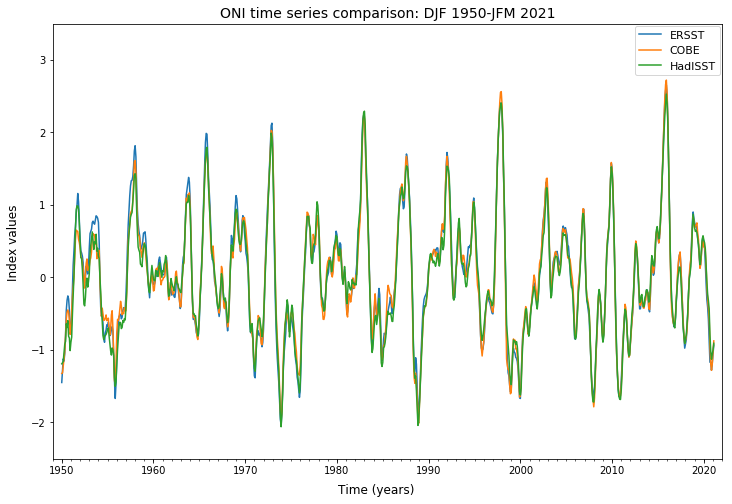

In [29]:
'''
    First, plot the ERSST, COBE and HadISST ONI data
    for time period of Jan. 1950-Feb. of 2021 to check
    if COBE and HadISST data resembles ERSST ONI.
'''

#To use for time series calculation and my ONI indexing
start_ind_ERSST = int(np.where(SSTdtime == '1892-01-01')[0])
start_ind_COBEHAD = int(np.where(SSTdtime == '1910-01-01')[0])

start_ind_plot = int(np.where(SSTdtime == '1950-01-01')[0])
start_ind_ERSST_compare = start_ind_plot - start_ind_ERSST

#ERSST
ERSST_sm_plot = ERSST_oni[start_ind_ERSST_compare:]

#COBE and HadISST
start_ind_COBEHAD = start_ind_plot - start_ind_COBEHAD

COBE_sm_plot = COBEHAD_oni[0,start_ind_COBEHAD:]
HAD_sm_plot = COBEHAD_oni[1,start_ind_COBEHAD:]

end_ind_plot = int(np.where(SSTdtime == '2021-02-01')[0]) + 1
time_axis = SSTdtime[start_ind_plot:end_ind_plot]

legend_info = ['ERSST','COBE','HadISST']

'''Plot data'''
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
ERSST_sm_data = ax.plot(time_axis,ERSST_sm_plot)
COBE_sm_data = ax.plot(time_axis,COBE_sm_plot)
HAD_sm_data = ax.plot(time_axis,HAD_sm_plot)
plt.title('ONI time series comparison: DJF 1950-JFM 2021',fontsize = '14')
    
#set x-limit of plot with datetime
ax.set_xlim([dt.date(1949, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(10)) 
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 

ax.set_ylim([-2.5,3.5])
ax.set_yticks(np.arange(-2,4,1))

# Set x and y labels
fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
#legend
fig.legend([ERSST_sm_data,COBE_sm_data,HAD_sm_data], labels=legend_info,
           bbox_to_anchor = (0.84,0.84),fontsize = 11)

In [30]:
'''Correlation of COBE/HadiSST ONI with ERSST ONI'''

s_idx_ERSST_oni = int(np.where(SSTdtime == '1892-01-01')[0])
s_idx_COBEHAD_oni = int(np.where(SSTdtime == '1910-01-01')[0])
s_idx_ERSST1 = s_idx_COBEHAD_oni - s_idx_ERSST_oni
s_idx_COBEHAD1 = 0

s_idx_GPCP = int(np.where(SSTdtime == '1950-01-01')[0])
s_idx_ERSST2 = s_idx_GPCP - s_idx_ERSST_oni
s_idx_COBEHAD2 = s_idx_GPCP - s_idx_COBEHAD_oni

print('\033[1m'+'Correlations with ERSST ONI'+'\033[0m'+'\n')
sst_type = ['COBE:','HadISST:']

for periods in range(2):
    if periods == 0:
        s_idx_ERSST = s_idx_ERSST1
        s_idx_COBEHAD = s_idx_COBEHAD1
        print('\033[4m'+'DJF 1910-JFM 2021'+'\033[0m')
    else:
        s_idx_ERSST = s_idx_ERSST2
        s_idx_COBEHAD = s_idx_COBEHAD2
        print('\033[4m'+'DJF 1950-JFM 2021'+'\033[0m')
    for inds in range(2):
        print(sst_type[inds],np.round(np.corrcoef(COBEHAD_oni[inds,s_idx_COBEHAD:],
                                                  ERSST_oni[s_idx_ERSST:])[0,1],3))
    
    if periods == 0:
        print('\n',end='') #'end=' makes it only print one white line, not two
    else:
        continue
        
print('\n',end='')

print('\033[1m'+'Correlations of COBE and HadISST ONI'+'\033[0m'+'\n')
for periods in range(2):
    if periods == 0:
        print('\033[4m'+'DJF 1910-JFM 2021'+'\033[0m')
        print(np.round(np.corrcoef(COBEHAD_oni[0,:],
                                   COBEHAD_oni[1,:])[0,1],3))
    else:
        print('\033[4m'+'DJF 1950-JFM 2021'+'\033[0m')
        print(np.round(np.corrcoef(COBEHAD_oni[0,s_idx_COBEHAD2:],
                                   COBEHAD_oni[1,s_idx_COBEHAD2:])[0,1],3))

Correlations with ERSST ONI

DJF 1910-JFM 2021
COBE: 0.961
HadISST: 0.946

DJF 1950-JFM 2021
COBE: 0.989
HadISST: 0.987

Correlations of COBE and HadISST ONI

DJF 1910-JFM 2021
0.958
DJF 1950-JFM 2021
0.989


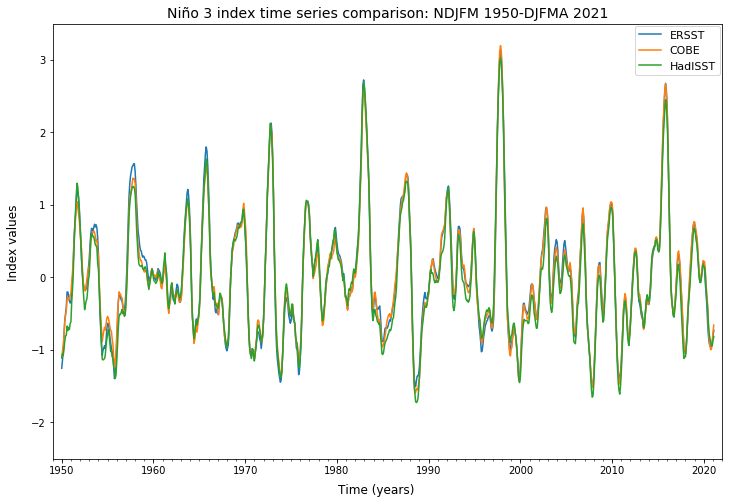

In [31]:
'''
    Plot ERSST, COBE, and HadISST Nino 3 index data for
    same purposes as with ONI in above cell.
'''

#To use for time series calculation and my ONI indexing
start_ind_ERSST = int(np.where(SSTdtime == '1892-01-01')[0])
start_ind_COBEHAD = int(np.where(SSTdtime == '1910-01-01')[0])

start_ind_plot = int(np.where(SSTdtime == '1950-01-01')[0])
start_ind_ERSST_compare = start_ind_plot - start_ind_ERSST

#ERSST
ERSST_sm_plot = ERSST_nino3idx[start_ind_ERSST_compare:]

#COBE and HadISST
start_ind_COBEHAD = start_ind_plot - start_ind_COBEHAD

COBE_sm_plot = COBEHAD_nino3idx[0,start_ind_COBEHAD:]
HAD_sm_plot = COBEHAD_nino3idx[1,start_ind_COBEHAD:]

end_ind_plot = int(np.where(SSTdtime == '2021-02-01')[0]) + 1
time_axis = SSTdtime[start_ind_plot:end_ind_plot]

legend_info = ['ERSST','COBE','HadISST']

'''Plot data'''
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
ERSST_sm_data = ax.plot(time_axis,ERSST_sm_plot)
COBE_sm_data = ax.plot(time_axis,COBE_sm_plot)
HAD_sm_data = ax.plot(time_axis,HAD_sm_plot)
plt.title('Niño 3 index time series comparison: NDJFM 1950-DJFMA 2021',fontsize = '14')
    
#set x-limit of plot with datetime
ax.set_xlim([dt.date(1949, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(10)) 
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 

ax.set_ylim([-2.5,3.5])
ax.set_yticks(np.arange(-2,4,1))

# Set x and y labels
fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
#legend
fig.legend([ERSST_sm_data,COBE_sm_data,HAD_sm_data], labels=legend_info,
           bbox_to_anchor = (0.84,0.84),fontsize = 11)

In [32]:
'''
   Correlation of COBE/HadiSST Niño 3 index with 
   ERSST Niño 3 index.
'''

s_idx_ERSST_nino3idx = int(np.where(SSTdtime == '1892-01-01')[0])
s_idx_COBEHAD_nino3idx = int(np.where(SSTdtime == '1910-01-01')[0])
s_idx_ERSST1 = s_idx_COBEHAD_nino3idx - s_idx_ERSST_nino3idx
s_idx_COBEHAD1 = 0

s_idx_GPCP = int(np.where(SSTdtime == '1950-01-01')[0])
s_idx_ERSST2 = s_idx_GPCP - s_idx_ERSST_nino3idx
s_idx_COBEHAD2 = s_idx_GPCP - s_idx_COBEHAD_nino3idx

print('\033[1m'+'Correlations with ERSST Niño 3 index'+'\033[0m'+'\n')
sst_type = ['COBE:','HadISST:']

for periods in range(2):
    if periods == 0:
        s_idx_ERSST = s_idx_ERSST1
        s_idx_COBEHAD = s_idx_COBEHAD1
        print('\033[4m'+'NDJFM 1910-DJFMA 2021'+'\033[0m')
    else:
        s_idx_ERSST = s_idx_ERSST2
        s_idx_COBEHAD = s_idx_COBEHAD2
        print('\033[4m'+'NDJFM 1950-DJFMA 2021'+'\033[0m')
    for inds in range(2):
        print(sst_type[inds],np.round(np.corrcoef(COBEHAD_nino3idx[inds,s_idx_COBEHAD:],
                                                  ERSST_nino3idx[s_idx_ERSST:])[0,1],3))
    
    if periods == 0:
        print('\n',end='')
    else:
        continue
        
print('\n',end='')
print('\033[1m'+'Correlations of COBE and HadISST Niño 3 index'+'\033[0m'+'\n')
for periods in range(2):
    if periods == 0:
        print('\033[4m'+'NDJFM 1910-DJFMA 2021'+'\033[0m')
        print(np.round(np.corrcoef(COBEHAD_nino3idx[0,:],COBEHAD_nino3idx[1,:])[0,1],3))
    else:
        print('\033[4m'+'NDJFM 1950-DJFMA 2021'+'\033[0m')
        print(np.round(np.corrcoef(COBEHAD_nino3idx[0,s_idx_COBEHAD2:],
                                   COBEHAD_nino3idx[1,s_idx_COBEHAD2:])[0,1],3))

Correlations with ERSST Niño 3 index

NDJFM 1910-DJFMA 2021
COBE: 0.973
HadISST: 0.951

NDJFM 1950-DJFMA 2021
COBE: 0.994
HadISST: 0.99

Correlations of COBE and HadISST Niño 3 index

NDJFM 1910-DJFMA 2021
0.963
NDJFM 1950-DJFMA 2021
0.99


In [33]:
'''
   Concatenate ERSST,COBE,and HadISST ONI and Niño 3 index
   for testing of NDI options against these Nino indices.

   All vectors will be from Jan. 1910-Feb. 2021
'''
start_nino_idx = int(np.where(SSTdtime == '1910-01-01')[0])
end_nino_idx = int(np.where(SSTdtime == '2021-02-01')[0])+1

arr_yr_len = end_nino_idx-start_nino_idx

ERSST_inds_s_idx = int(np.where(SSTdtime == '1892-01-01')[0])
s_idx_store = start_nino_idx - ERSST_inds_s_idx

oni = np.zeros((3,arr_yr_len))
nino3idx = np.zeros((3,arr_yr_len))

#0 = ERSST, 1 = COBE, 2 = HadISST
oni[0,:] = ERSST_oni[s_idx_store:]
oni[1:,:] = COBEHAD_oni

nino3idx[0,:] = ERSST_nino3idx[s_idx_store:]
nino3idx[1:,:] = COBEHAD_nino3idx

## Extract ONI and Niño 3 index values that <br> correspond to standard seasons and one <br> month lead to standard season

In [34]:
'''   
   Retrieve index values that correspond to center month of each standard 
   season being compared since ONI and Niño 3 index use rolling means
   for index values. 
   
   For example, to get index values to compare with MAM 1979-2020 of PC 1, 
   I want to extract April's ONI Niño 3 index value, which is MAM 1979-2020
   and FMAMJ 1979-2020 for Niño 3 index since it uses 5 month running means.
   
   For one month leads, I would extract March's value for each index (FMA 1979-2020 
   for ONI and JFMAM 1979-2020 for Niño 3 index)
'''
syear_nino_idx = 1910
eyear_nino_idx = SSTdtime[-1].year

arr_yr_len = eyear_nino_idx-syear_nino_idx

oni_seasons = np.zeros((3,4,arr_yr_len))
nino3idx_seasons = np.zeros((3,4,arr_yr_len))

oni_seasons_lead = np.zeros((3,4,arr_yr_len))
nino3idx_seasons_lead = np.zeros((3,4,arr_yr_len))

for sst_type in range(3):
    for season in range(4):
        for year in range(arr_yr_len):
            #mth_idx first indexes April (MAM for ONI and FMAMJ
            #for Niño 3 index)
            mth_idx = 3 + season*3 + year*12
            oni_seasons[sst_type,season,year] = oni[sst_type,mth_idx]
            nino3idx_seasons[sst_type,season,year] = nino3idx[sst_type,mth_idx]
            
            #First extracts FMA for ONI and JFMAM for 
            #Niño 3 index
            mth_idx_lead = 2 + season*3 + year*12
            oni_seasons_lead[sst_type,season,year] = oni[sst_type,mth_idx_lead]
            nino3idx_seasons_lead[sst_type,season,year] = nino3idx[sst_type,mth_idx_lead]

## Region locations of ENSO indices used for <br> NDI options tests

### ONI uses Niño 3.4 region

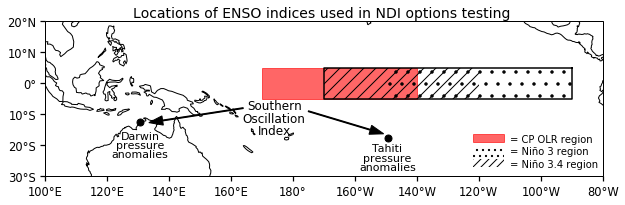

In [35]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines(resolution='110m')
ax.set_extent([100,280,-30,20], crs=ccrs.PlateCarree())
#Latitude (Longitude) labels on left (bottom) of figure
ax.xlabels_top = False
ax.xlabels_bottom = True
ax.ylabels_left = True
ax.ylabels_right = False
ax.set_xticks([100,120,140,160,180,-160,-140,-120,-100,-80],crs = ccrs.PlateCarree())

ax.set_yticks([-30,-20,-10,0,10,20], crs = ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#Make tickmark and tick labels larger
#for improved readability
ax.tick_params(axis='both',labelsize=11.5)
ax.tick_params(width=1.25,length=5)

''' Central Pacific (CP) OLR index- 5°N-5°S,170°E-140°W'''
ax.add_patch(Rectangle((-10, -5), 50, 10,color='r',alpha=0.6))

'''Add outline and hatched area for Niño 3 and 3.4 (used for ONI) regions'''
ninoreg_lons = [90,10,10,90,90]
ninoreg_lats = [5,5,-5,-5,5]
ninoreg = ax.plot(ninoreg_lons,ninoreg_lats,color='k',linestyle = 'solid')

ax.add_patch(Rectangle((30, -5), 60, 10,fill=False,hatch='.',linewidth=0))
ax.add_patch(Rectangle((10, -5), 50, 10,fill=False,hatch='//',linewidth=0))


'''Plot and label locations used for Southern Oscillation Index (Tahiti and Darwin)'''
tahiti = ax.plot(30.6,-17.7,'o',color='k',ms=7)
ax.text(30.6,-22,'Tahiti',horizontalalignment='center',fontsize=11)
ax.text(30.6,-25,'pressure',horizontalalignment='center',fontsize=11)
ax.text(30.6,-28,'anomalies',horizontalalignment='center',fontsize=11)

darwin = ax.plot(-49.2,-12.46,'o',color='k',ms=7)
ax.text(-49.2,-18,'Darwin',horizontalalignment='center',fontsize=11)
ax.text(-49.2,-21,'pressure',horizontalalignment='center',fontsize=11)
ax.text(-49.2,-24,'anomalies',horizontalalignment='center',fontsize=11)

#add SOI label and arrows pointing to locations
ax.text(-6,-8.5,'Southern',horizontalalignment='center',fontsize=12)
ax.text(-6,-12.5,'Oscillation',horizontalalignment='center',fontsize=12)
ax.text(-6,-16.5,'Index',horizontalalignment='center',fontsize=12)

ax.arrow(-16,-8,-26,-4,width=0.3,head_width=3,color='k')
ax.arrow(5,-9,20,-6,width=0.3,head_width=3,color='k')

'''Add custom legend for hatched and shaded regions'''
ax.add_patch(Rectangle((58, -19), 10, 2.5,color='r',alpha=0.6))
ax.text(70,-19,'= CP OLR region')

ax.add_patch(Rectangle((58, -24), 10, 3.5,fill=False,hatch='..',linewidth=0))
ax.text(70,-23,'= Niño 3 region')

ax.add_patch(Rectangle((58, -27), 10, 2.5,fill=False,hatch='///',linewidth=0))
ax.text(70,-27,'= Niño 3.4 region')

title_fig = 'Locations of ENSO indices used in NDI options testing'
header = fig.text(0.51,0.7,title_fig, ha='center', va='center',fontsize = 14)

# NDI options relationship to ENSO atmospheric <br> response compared to Niño SST indices
## 1. Standard season correlations (zero month lead)
### *Southern Oscillation Index (SOI)*

In [36]:
'''
   Load in SOI data from Australia Bureau of Meteorology
   
   SOI data is the monthly difference of pressure
   anomalies between Tahiti and Darwin.
'''

#Data from February of 1876 to February of 2022
filename_soi = ENSOdir + "ENSO_indices\\soi_data_au_gov.csv"
soi_df = pd.read_csv(filename_soi)

#get numeric values from csv file
soi_datasheet = soi_df.values
soi_data = soi_datasheet[:,1] #exclude year/month labels from array

In [37]:
'''Trim SOI to be same length as Niño indices'''

#Use DateTime Index used to make SST datasets the
#same length to have common monthly time range

soi_beg_idx = int(np.where(SSTdtime_set == '1876-02-01')[0])

ENSO_inds_beg_idx = int(np.where(SSTdtime_set == '1910-01-01')[0])
ENSO_inds_end_idx = int(np.where(SSTdtime_set == '2021-02-01')[0]) + 1

soi_s_ind = ENSO_inds_beg_idx - soi_beg_idx
soi_end_ind = ENSO_inds_end_idx - soi_beg_idx

soi_trim = np.copy(soi_data)
soi_trim = soi_trim[soi_s_ind:soi_end_ind]

In [38]:
'''Calculate SOI seasonal averages'''

soi_season = np.zeros((4,arr_yr_len))
for season in range(4):
    for year in range(arr_yr_len):
        month_idx = 2 + year*12 + 3*season
        soi_season[season,year] = np.mean(soi_trim[month_idx:month_idx+3])  

In [39]:
'''
   Trim seasonal NDI option time series 
   to be same length as Niño indices
'''
beg_yr_ndi = 1891
beg_yr_ENSO_inds = 1910
s_idx_ndi = beg_yr_ENSO_inds-beg_yr_ndi

NDI_opts_seasons_trim = NDI_opts_seasons[:,:,:,s_idx_ndi:]
NDI_opts_seasons_lead_trim = NDI_opts_seasons_lead[:,:,:,s_idx_ndi:]

In [40]:
'''Common labels used in below cells'''

#header labels for SST dataset type
sst_dataset = ['ERSST','COBE','HadISST']
#labels for pandas dataframe
season_labels = ['MAM','JJA','SON','DJF']
NDI_labels = ['NDI Opt 1','NDI Opt 2','NDI Opt 3','NDI Opt 4',
              'NDI Opt 5','NDI Opt 6','ONI','Niño 3 idx']

### Correlation tables

In [41]:
'''
   Correlations of SOI for 2 periods: 
   1910-2021 and 1979-2021
   
          Reminder
               
   ***Standard season definitions***
   
   MAM = March, April, May
   JJA = June, July, August
   SON = September, October, November
   DJF = December, January, February
   
   Correlation of average values of NDI options
   and Niño indices with ENSO metrics for each
   standard season (zero month lead). 
   
   For example, for SOI correlate MAM of NDI 
   options and Niño indices for the corresponding
   time period with SOI.
'''

#Labels for test with NDI
period_label = 'Time period:'
period_length = ['1910-2021','1979-2021']

print('%s%s%s %s' %('\033[1m','Correlations with Southern Oscillation Index','\033[0m',
                        '\n'))

#Correlate and print correlations using pandas
syear_gpcp = 1979
syear_inds = 1910
s_idx_data = syear_gpcp - syear_sst

for test in range(2):
    print('%s %s%s%s%s%s' % ('       ','\033[1m',period_label,period_length[test],'\033[0m','\n'))
    if test == 0:
        s_idx = 0
    else:
        s_idx = s_idx_data
    for sst_type in range(3):
        print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
        c = np.zeros((8,4))
        for option in range(8):
            for season in range(4):
                if option < 6:
                    c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx:],
                                                   soi_season[season,s_idx:])[0,1]
                elif option == 6:
                    c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx:],
                                                   soi_season[season,s_idx:])[0,1]
                else:
                    c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx:],
                                                   soi_season[season,s_idx:])[0,1]
        
        #Flip sign of correlation since SOI has opposite 
        #sign for time series for ENSO monitoring compared 
        #to NDI, ONI and Niño 3 index. Makes it easier to 
        #read pandas output and I'm interested in looking at
        #the strength of the relationship between SOI and
        #NDI options/Niño SST indices.
    
        c = np.round(c,2)*-1
        c_df = pd.DataFrame(c)
        c_df.index = NDI_labels
        c_df.columns = season_labels
        pd.set_option("display.colheader_justify","center")
        print(c_df,"\n")

Correlations with Southern Oscillation Index 

        Time period:1910-2021

---------------- ERSST ---------------- 

             MAM   JJA   SON   DJF
NDI Opt 1   0.65  0.74  0.80  0.83
NDI Opt 2   0.66  0.76  0.81  0.84
NDI Opt 3   0.62  0.70  0.76  0.82
NDI Opt 4   0.63  0.72  0.77  0.83
NDI Opt 5   0.60  0.73  0.77  0.81
NDI Opt 6   0.69  0.74  0.79  0.84
ONI         0.72  0.71  0.80  0.84
Niño 3 idx  0.67  0.65  0.76  0.81 

---------------- COBE ---------------- 

             MAM   JJA   SON   DJF
NDI Opt 1   0.62  0.70  0.79  0.82
NDI Opt 2   0.63  0.71  0.80  0.83
NDI Opt 3   0.61  0.67  0.75  0.81
NDI Opt 4   0.62  0.68  0.75  0.82
NDI Opt 5   0.61  0.67  0.76  0.79
NDI Opt 6   0.66  0.70  0.80  0.82
ONI         0.73  0.72  0.80  0.84
Niño 3 idx  0.67  0.65  0.76  0.81 

---------------- HadISST ---------------- 

             MAM   JJA   SON   DJF
NDI Opt 1   0.64  0.73  0.79  0.83
NDI Opt 2   0.65  0.75  0.81  0.83
NDI Opt 3   0.62  0.72  0.76  0.82
NDI Opt 4   0.62  0.7

### *GPCP global precipitation PC 1*

In [42]:
'''
   Load seasonal GPCP PC 1 time series of global and non-tropical for all seasons.
   
   Non-tropical is the PC time series of precipitation that does not include
   data in the tropical Pacific region.
'''
dir_path_GPCP_pc1 = ENSOdir + str("GPCP\\GPCP_PC1_timeseries\\")
filename_global_pc1 = dir_path_GPCP_pc1 + str("global_pc1_1979_djf2021.npy")
filename_extratrop_pc1 = dir_path_GPCP_pc1 + str("extratrop_pc1_1979_djf2021.npy")

GPCP_global_pc1 = np.load(filename_global_pc1)
GPCP_extratrop_pc1 = np.load(filename_extratrop_pc1)

### Correlation tables

In [43]:
syear_gpcp = 1979
syear_inds = 1910
s_idx_data = syear_gpcp - syear_inds

period_label = 'Time period: 1979-2021'
print('%s%s %s%s%s%s%s' % (' ','\033[1m','Correlations with GPCP global PC 1',
                     '\n','        ',period_label,'\033[0m'),'\n')
for sst_type in range(3):
    print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
    c = np.zeros((8,4))
    for option in range(8):
        for season in range(4):
            if option < 6:
                c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx_data:],
                                               GPCP_global_pc1[season,:])[0,1]
            elif option == 6:
                c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx_data:],
                                               GPCP_global_pc1[season,:])[0,1]
            else:
                c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_data:],
                                               GPCP_global_pc1[season,:])[0,1]
                
    c = np.round(c,3)
    c_df = pd.DataFrame(c)
    c_df.index = NDI_labels
    c_df.columns = season_labels
    pd.set_option("display.colheader_justify","center")
    print(c_df,"\n")

  Correlations with GPCP global PC 1
        Time period: 1979-2021 

---------------- ERSST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.859  0.899  0.952  0.961
NDI Opt 2   0.856  0.884  0.953  0.964
NDI Opt 3   0.879  0.867  0.946  0.963
NDI Opt 4   0.878  0.846  0.949  0.967
NDI Opt 5   0.854  0.834  0.951  0.966
NDI Opt 6   0.800  0.933  0.934  0.945
ONI         0.832  0.896  0.936  0.957
Niño 3 idx  0.891  0.830  0.921  0.921 

---------------- COBE ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.893  0.911  0.950  0.961
NDI Opt 2   0.887  0.886  0.948  0.962
NDI Opt 3   0.903  0.888  0.943  0.963
NDI Opt 4   0.883  0.850  0.941  0.965
NDI Opt 5   0.889  0.833  0.931  0.963
NDI Opt 6   0.832  0.925  0.927  0.943
ONI         0.845  0.903  0.935  0.959
Niño 3 idx  0.878  0.833  0.926  0.921 

---------------- HadISST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.911  0.900  0.949  0.964
NDI Opt 2   0.914  

### *GPCP non-tropical PC 1*

### Correlation tables

In [44]:
syear_gpcp = 1979
syear_inds = 1910
s_idx_data = syear_gpcp - syear_inds

period_label = 'Time Period: 1979-2021'
print('%s%s%s%s%s %s' % ('\033[1m','Correlations with GPCP non-tropical PC 1',
                        '\n','        ',period_label,'\033[0m'),'\n')
      
for sst_type in range(3):
    print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
    c = np.zeros((8,4))
    for option in range(8):
        for season in range(4):
            if option < 6:
                c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx_data:],
                                               GPCP_extratrop_pc1[season,:])[0,1]
            elif option == 6:
                c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx_data:],
                                               GPCP_extratrop_pc1[season,:])[0,1]
            else:
                c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_data:],
                                               GPCP_extratrop_pc1[season,:])[0,1]
            
            #Flipping sign of correlation (for MAM and JJA),
            #since sign of PC is arbitrary
            if c[option,season] < 0:
                c[option,season] = c[option,season]*-1
            else:
                continue
    
    c = np.round(c,3)
        
    c_df = pd.DataFrame(c)
    c_df.index = NDI_labels
    c_df.columns = season_labels
    pd.set_option("display.colheader_justify","center")
    print(c_df,"\n")

Correlations with GPCP non-tropical PC 1
        Time Period: 1979-2021  

---------------- ERSST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.725  0.675  0.682  0.905
NDI Opt 2   0.725  0.656  0.688  0.909
NDI Opt 3   0.730  0.651  0.662  0.899
NDI Opt 4   0.729  0.619  0.670  0.901
NDI Opt 5   0.714  0.609  0.681  0.896
NDI Opt 6   0.688  0.684  0.700  0.914
ONI         0.737  0.595  0.700  0.906
Niño 3 idx  0.756  0.521  0.678  0.858 

---------------- COBE ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.737  0.674  0.681  0.905
NDI Opt 2   0.728  0.664  0.674  0.907
NDI Opt 3   0.726  0.649  0.665  0.900
NDI Opt 4   0.703  0.630  0.658  0.900
NDI Opt 5   0.703  0.611  0.648  0.895
NDI Opt 6   0.715  0.696  0.684  0.906
ONI         0.749  0.595  0.702  0.909
Niño 3 idx  0.749  0.502  0.689  0.860 

---------------- HadISST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.788  0.629  0.695  0.905
NDI Opt 2   0.

### *Central Pacific (CP) OLR index*

In [45]:
'''
  Load in CP OLR index data from CPC. Data available 
  from Jan 1979 to February 2022.
  
  CP OLR index uses period of 1991-2020 as climate
  mean to calculate anomalies.
'''

#Data from Jan 1979 to February 2022 
filename_cp_olr = ENSOdir + "ENSO_indices\\cp_olr_cpc_data.csv"
cp_olr_df = pd.read_csv(filename_cp_olr)

#get numeric values from csv file
cp_olr_datasheet = cp_olr_df.values
cp_olr_vec = cp_olr_datasheet[:,2:] #exclude year and month labels from array

#remove values past February of 2021
#to match length of SST data
cp_olr = cp_olr_vec[:-12]

In [46]:
'''Calculate seasonal averages of CP OLR index'''
syear = 1979
eyear = 2021

arr_yr_len = eyear-syear
cp_olr_seasons = np.zeros((4,arr_yr_len))

for season in range(4):
    for year in range(arr_yr_len):
        mth_idx = 2 + season*3 + year*12
        cp_olr_seasons[season,year] = np.mean(cp_olr[mth_idx:mth_idx+3])

### Correlation tables

In [47]:
'''
   Correlations of NDI options/Niño indices and
   seasonal CP OLR Index
'''


syear_cp_olr = 1979
syear_inds = 1910
s_idx_data = syear_cp_olr - syear_inds

'''Label for correlation tables'''

period_label = 'Time period: 1979-2021'

print('%s %s%s%s%s%s%s' % ('   ','\033[1m','Correlations with CP OLR index',
                         '\n','        ',period_label,'\033[0m'),'\n')

'''
   First, calculate CP OLR correlations with GPCP global
   PC 1. Benchmark relationship to compare with NDI
   options and Niño indices.
   
   Omit non-tropical PC 1 since it does not measure
   the atmospheric response in the region that drives ENSO
   (tropical Pacific).
'''
c = np.zeros((1,4))
for season in range(4):
    c[:,season] = np.round(np.corrcoef(cp_olr_seasons[season,:],
                             GPCP_global_pc1[season,:])[0,1],3)*-1

print('%s %s%s%s %s' % ('--------','\033[1m','Global precipitation','\033[0m','--------'),'\n')
label = ['GPCP PC 1']
c_df = pd.DataFrame(c)
c_df.index = label
c_df.columns = season_labels
print(c_df,'\n')

'''Correlations NDI options and Niño indices'''
for sst_type in range(3):
    print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
    c = np.zeros((8,4))
    for option in range(8):
        for season in range(4):
            if option < 6:
                c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx_data:],
                                               cp_olr_seasons[season,:])[0,1]
            elif option == 6:
                c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx_data:],
                                               cp_olr_seasons[season,:])[0,1]
            else:
                c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_data:],
                                               cp_olr_seasons[season,:])[0,1]
    #Flip sign of correlation to be positive
    #since OLR index has opposite sign of
    #SST indices (strength of relationship
    #to CP OLR index is what I'm interested 
    #in viewing)
    c = np.round(c,3)*-1
    c_df = pd.DataFrame(c)
    c_df.index = NDI_labels
    c_df.columns = season_labels
    pd.set_option("display.colheader_justify","center")
    print(c_df,"\n")

    Correlations with CP OLR index
        Time period: 1979-2021 

-------- Global precipitation -------- 

            MAM    JJA    SON    DJF 
GPCP PC 1  0.898  0.842  0.905  0.978 

---------------- ERSST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.880  0.936  0.924  0.947
NDI Opt 2   0.877  0.932  0.918  0.949
NDI Opt 3   0.892  0.944  0.940  0.959
NDI Opt 4   0.889  0.944  0.938  0.962
NDI Opt 5   0.897  0.939  0.930  0.962
NDI Opt 6   0.804  0.872  0.872  0.917
ONI         0.837  0.898  0.884  0.927
Niño 3 idx  0.819  0.912  0.902  0.896 

---------------- COBE ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.890  0.921  0.930  0.946
NDI Opt 2   0.879  0.921  0.930  0.946
NDI Opt 3   0.891  0.930  0.947  0.957
NDI Opt 4   0.870  0.926  0.950  0.960
NDI Opt 5   0.906  0.927  0.939  0.957
NDI Opt 6   0.839  0.842  0.874  0.918
ONI         0.847  0.873  0.882  0.929
Niño 3 idx  0.822  0.908  0.902  0.895 

---------------- HadISST

### *Southern United States precipitation using NClimDiv data*

### United States regions impacted by ENSO events

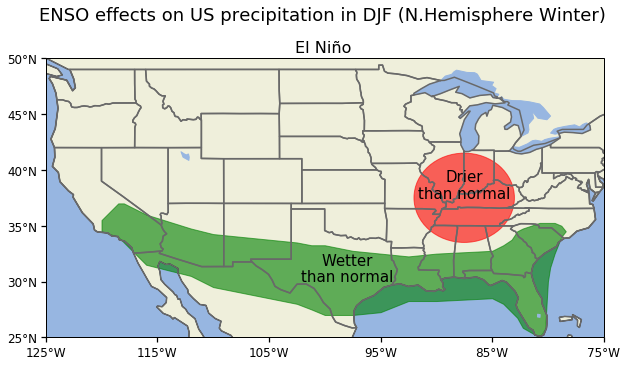

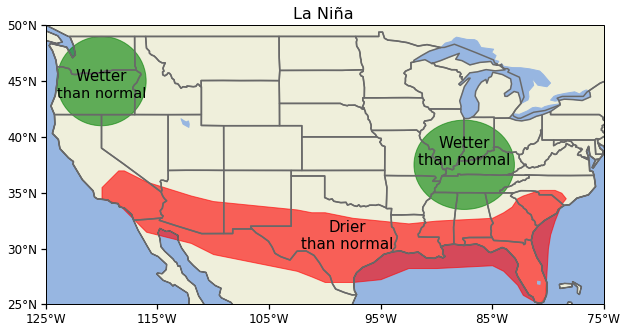

In [48]:
'''
   Map displaying US regions that experience
   ENSO teleconnections. 
'''


'''
   Figure 1: El Niño 
'''
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines(resolution='110m')
ax.set_extent([235,285,25,50], crs=ccrs.PlateCarree())

'''
   Add land,lakes,ocean as well as
   country, state, and ocean borders
'''

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS,edgecolor='dimgrey',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='dimgrey',linewidth=1.5)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='dimgrey',linewidth=1.5)

#Latitude (Longitude) labels on left (bottom) of figure
ax.xlabels_top = False
ax.xlabels_bottom = True
ax.ylabels_left = True
ax.ylabels_right = False
ax.set_xticks([-125,-115,-105,-95,-85,-75],crs = ccrs.PlateCarree())
ax.set_yticks([25,30,35,40,45,50], crs = ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

'''
   Increase the tick label size and tick mark
   width slightly for improved readability
'''
ax.tick_params(axis='both',labelsize=12)
ax.tick_params(width=1.25,length=5)

'''
   Make shapes to display US region that experiences
   ENSO impacts
'''

lats = [60,61.5,62,64,68,70,75,         #CA to NM
      77.5,78.8,80,82.5,85,             #TX
      87.5,90,95,                       #LA to AL
      96,96.75,97.25,97.75,99.25,99.75, #GA/FL
      100,100.2,100.6,101.2,101.6       #SC
      ]

lon_north = [35.5,37,37,36,34.75,34.25,33.75,     #CA to NM
           33.5,33.25,33.25,32.75,32.5,           #TX 
           32.25,32.5,32.75,                      #LA to GA
           33.25,33.75,34.5,34.75,35.25,35.25,    #FL
           35.25,35.25,35.25,35,34.5              #SC/NC
          ]

lon_south = [34.5,34,33.5,31.5,30.5,29.5,28.5,    #CA to NM
           28,27.5,27,27,27.25,                   #TX
           28.25,28.25,28.5,                      #LA to AL
           28,27.25,26.75,25.85,25,25.75,         #GA/FL 
           30,31.25,32.5,34,34.5                  #SC
          ]

#Shade the area
ax.fill_between(lats,lon_north,lon_south,             
                 color='green',       
                 alpha=0.6)         

label = ax.text(82,31.5,"Wetter",fontsize=15,horizontalalignment='center') 
label2 = ax.text(82,30,"than normal",fontsize=15,horizontalalignment='center')

eastcentral = ax.add_patch(Ellipse((92.5,37.5),9,8,color='red',alpha=0.6))

label3 = ax.text(92.5,39,"Drier",fontsize=15,horizontalalignment='center')
label4 = ax.text(92.5,37.5,"than normal",fontsize=15,horizontalalignment='center')

#Add Header for both figures
main_title = 'ENSO effects on US precipitation in DJF (N.Hemisphere Winter)'
#Title figure 1
main_header = fig.text(0.51,0.925,main_title, ha='center', va='center',fontsize = 18)
#Add title
title_fig = 'El Niño'
header = fig.text(0.51,0.85,title_fig, ha='center', va='center',fontsize = 16)

'''
   Figure 2: La Niña 
   ...
   Mainly has opposite effect on southern/east central US compared to El Niño
'''

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines(resolution='110m')
ax.set_extent([235,285,25,50], crs=ccrs.PlateCarree())
#Add land,lakes,ocean, 
#and country, state, and ocean borders

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS,edgecolor='dimgrey',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='dimgrey',linewidth=1.5)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='dimgrey',linewidth=1.5)

ax.xlabels_top = False
ax.xlabels_bottom = True
ax.ylabels_left = True
ax.ylabels_right = False

ax.set_xticks([-125,-115,-105,-95,-85,-75],crs = ccrs.PlateCarree())
ax.set_yticks([25,30,35,40,45,50], crs = ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.tick_params(axis='both',labelsize=12)
ax.tick_params(width=1.25,length=5)

ax.fill_between(lats,lon_north,lon_south,             
                 color='red',       
                 alpha=0.6)

label = ax.text(82,31.5,"Drier",fontsize=15,horizontalalignment='center') 
label2 = ax.text(82,30,"than normal",fontsize=15,horizontalalignment='center')

eastcentral = ax.add_patch(Ellipse((92.5,37.5),9,8,color='g',alpha=0.6))
label3 = ax.text(92.5,39,"Wetter",fontsize=15,horizontalalignment='center')
label4 = ax.text(92.5,37.5,"than normal",fontsize=15,horizontalalignment='center')

pac_nw_la_nina = ax.add_patch(Ellipse((60,45),8,8,color='g',alpha=0.6))
label5 = ax.text(60,45,"Wetter",fontsize=15,horizontalalignment='center')
label6 = ax.text(60,43.5,"than normal",fontsize=14.5,horizontalalignment='center')

title_fig = 'La Niña'
header = fig.text(0.51,0.85,title_fig, ha='center', va='center',fontsize = 16)

### NClimDiv regions that experience strongest ENSO impacts

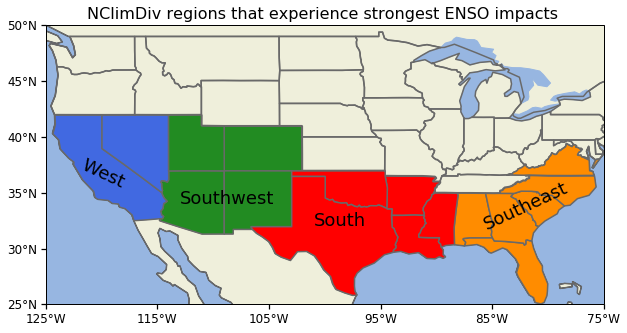

In [49]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines(resolution='110m')
ax.set_extent([235,285,25,50], crs=ccrs.PlateCarree())

#Add land,lakes,ocean, 
#and country, state, and ocean borders
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS,edgecolor='dimgrey',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='dimgrey',linewidth=1.5)

ax.xlabels_top = False
ax.xlabels_bottom = True
ax.ylabels_left = True
ax.ylabels_right = False

ax.set_xticks([-125,-115,-105,-95,-85,-75],crs = ccrs.PlateCarree())
ax.set_yticks([25,30,35,40,45,50], crs = ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.tick_params(axis='both',labelsize=12)
ax.tick_params(width=1.25,length=5)

states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', 
                                     name='admin_1_states_provinces_lakes')

'''
   Here, I find the order in which states are listed
   in the shape file separately, then pass it in the 
   following for loop to shade the relevant NClimDiv 
   regions so it works properly.
   
   For the removal of the padding "\x00" from below for
   loop otuput to work, I have to append each state in 
   it's own separate bracket. This means I have to "bracket"
   my NClimDiv state arrays to produce an exact match 
   of the state list from shape file to shade the 
   desired states.
'''
reader = shpreader.Reader(states_shp)
states_list = []
for record in reader.records():
    name = record.attributes['name']
    states_list.append([name])
    
states_list_order = [[states_list.replace('\x00', '') for states_list in x] for x in states_list]

nclimdiv_south = (['Texas'],['Oklahoma'],['Arkansas'],['Louisiana'],['Mississippi'])
nclimdiv_se = (['Alabama'],['Georgia'],['Florida'],['South Carolina'],['North Carolina'],['Virginia'])
nclimdiv_sw = (['New Mexico'],['Colorado'],['Utah'],['Arizona'])
nclimdiv_west = (['Nevada'],['California'])

for state_names, state in zip(states_list_order, reader.geometries()):
    #name = record.attributes['name']
    if state_names in nclimdiv_south:
        shading = 'red'
    elif state_names in nclimdiv_se:
        shading = 'DarkOrange'
    elif state_names in nclimdiv_sw:
        shading = 'forestgreen'
    elif state_names in nclimdiv_west:
        shading = 'royalblue'
    else:
        shading = 'none'
        
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=shading, edgecolor='dimgrey',linewidth=1.5)
    
south_label = ax.text(79,32,'South',fontsize=18)
se_label = ax.text(94,35,'Southeast',fontsize=18,rotation=25)
sw_label = ax.text(67,34,'Southwest',fontsize=18)
west_label = ax.text(58,37,'West',fontsize=18,rotation=-25)
title_fig = 'NClimDiv regions that experience strongest ENSO impacts'
header = fig.text(0.51,0.85,title_fig, ha='center', va='center',fontsize = 16)

### Load in regional NClimDiv data

In [50]:
'''
   Here, I take the mean of standard season precipitation
   in NClimDiv regions listed below. Data is from
   National Center of Environmental Information (NCEI).
   .....
   Region IDs displayed in above figure:
   104 = Southeast
   106 = South
   107 = Southwest
   109 = West
   .....
   These are the regions that are most strongly affected
   by ENSO.
   
   ****Method for tests with NDI + Niño indices****
   
   Take the mean of these listed regions precipitation 
   values for each standard season to evaluate 
   relationship NDI options and Niño SST indices have
   with seasonal precipitation in these regions.
'''

'''
   Load in data precipitation data for US regions 
   from nClimdiv
'''

nclimdiv = ENSOdir + "nclimdiv\\"
nclimdiv_mam_file = nclimdiv + "nclimdiv_usa_mam.csv"
nclimdiv_jja_file = nclimdiv + "nclimdiv_usa_jja.csv"
nclimdiv_son_file = nclimdiv + "nclimdiv_usa_son.csv"
nclimdiv_djf_file = nclimdiv + "nclimdiv_usa_djf.csv"

nclimdiv_mam = pd.read_csv(nclimdiv_mam_file)
nclimdiv_jja = pd.read_csv(nclimdiv_jja_file)
nclimdiv_son = pd.read_csv(nclimdiv_son_file)
nclimdiv_djf = pd.read_csv(nclimdiv_djf_file)

'''
   There are fill values at the end of the csv file.
   Omit them.
   
   Seasonal nClimDiv starts in MAM 1895 and ends in
   DJF 2021
   
   Units: inches
'''
start_nclimdiv = 1895
end_nclimdiv = 2021

nyears_nclimdiv = end_nclimdiv - start_nclimdiv

nclimdiv_mam = nclimdiv_mam.values
nclimdiv_jja = nclimdiv_jja.values
nclimdiv_son = nclimdiv_son.values
nclimdiv_djf = nclimdiv_djf.values

#Omit year label at the beginning of each row
nclimdiv_mam_data = nclimdiv_mam[:nyears_nclimdiv,1:]
nclimdiv_jja_data = nclimdiv_jja[:nyears_nclimdiv,1:]
nclimdiv_son_data = nclimdiv_son[:nyears_nclimdiv,1:]
nclimdiv_djf_data = nclimdiv_djf[:nyears_nclimdiv,1:]

#throw seasonal nclimdiv region precipitation arrays
#into single array
ncdiv_precip_seasons = np.zeros((4,nyears_nclimdiv,9))
ncdiv_precip_seasons[0,:,:] = nclimdiv_mam_data
ncdiv_precip_seasons[1,:,:] = nclimdiv_jja_data
ncdiv_precip_seasons[2,:,:] = nclimdiv_son_data
ncdiv_precip_seasons[3,:,:] = nclimdiv_djf_data

### Calculate mean of all four regions standard season precipitation values <br> displayed in above figure

In [51]:
'''
   Take average standard season precipitation
   for four regions mentioned above
'''

ncdiv_south = np.zeros((4,nyears_nclimdiv,4)) #seasons,years,regions
ncdiv_south[:,:,0] = ncdiv_precip_seasons[:,:,3]
ncdiv_south[:,:,1] = ncdiv_precip_seasons[:,:,5]
ncdiv_south[:,:,2] = ncdiv_precip_seasons[:,:,6]
ncdiv_south[:,:,3] = ncdiv_precip_seasons[:,:,8]

#standard season mean of combined regions
#for each year
ncdiv_south_mean = np.zeros((4,nyears_nclimdiv))
for season in range(4):
    for year in range(nyears_nclimdiv):
        ncdiv_south_mean[season,year] = np.mean(ncdiv_south[season,year,:])

### Correlation tables

In [52]:
'''
   Test 1: 1910-2021
   Test 2: 1950-2021
   Test 3: 1979-2021
   
   Include test 2 time period because that marks the
   beginning of more reliable observational 
   SST data. Significant correlation difference
   between period of 1910-2021 and 1979-2021
'''

syear_nclimdiv = 1895
syear_inds = 1910

s_idx_inds_1 = 0
s_idx_nclimdiv_1 = syear_inds - syear_nclimdiv

syear_test2 = 1950
s_idx_nclimdiv_2 = syear_test2 - syear_nclimdiv
s_idx_inds_2 = syear_test2 - syear_inds

syear_gpcp = 1979
s_idx_inds_3 = syear_gpcp - syear_inds
s_idx_nclimdiv_3 = syear_gpcp - syear_nclimdiv


s_idx_nclimdiv_loop = [s_idx_nclimdiv_1,s_idx_nclimdiv_2,s_idx_nclimdiv_3]
s_idx_inds_loop = [s_idx_inds_1,s_idx_inds_2,s_idx_inds_3]

period_label = ['Time Period: 1910-2021','Time Period: 1950-2021',
                'Time Period: 1979-2021']

#header label for all tables
print('%s%s%s%s' % ('\033[1m','Correlations with NClimDiv Southern US','\033[0m','\n'))

for tests in range(3):
    s_idx_nclimdiv = s_idx_nclimdiv_loop[tests]
    s_idx_inds = s_idx_inds_loop[tests] 
    print('%s %s%s%s%s' % ('        ','\033[1m',period_label[tests],'\033[0m','\n'))
   
    for sst_type in range(3):
        print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
        c = np.zeros((8,4))
        for option in range(8):
            for season in range(4):
                if option < 6:
                    c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx_inds:],
                                                   ncdiv_south_mean[season,s_idx_nclimdiv:])[0,1]
                elif option == 6:
                    c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx_inds:],
                                                   ncdiv_south_mean[season,s_idx_nclimdiv:])[0,1]
                else:
                    c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_inds:],
                                                   ncdiv_south_mean[season,s_idx_nclimdiv:])[0,1]
            
            #Flipping sign of correlation (for MAM and JJA),
            #since sign of PC is arbitrary
          #  if c[option,season] < 0:
          #      c[option,season] = c[option,season]*-1
          #  else:
          #      continue
    
        c = np.round(c,3)
        
        c_df = pd.DataFrame(c)
        c_df.index = NDI_labels
        c_df.columns = season_labels
        pd.set_option("display.colheader_justify","center")
        print(c_df,"\n")

Correlations with NClimDiv Southern US

         Time Period: 1910-2021

---------------- ERSST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.263  0.068  0.373  0.417
NDI Opt 2   0.267  0.084  0.375  0.416
NDI Opt 3   0.250  0.072  0.378  0.407
NDI Opt 4   0.253  0.086  0.378  0.403
NDI Opt 5   0.219  0.098  0.377  0.384
NDI Opt 6   0.341  0.066  0.363  0.430
ONI         0.351  0.047  0.364  0.415
Niño 3 idx  0.346 -0.038  0.370  0.455 

---------------- COBE ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.289  0.080  0.354  0.452
NDI Opt 2   0.285  0.095  0.357  0.450
NDI Opt 3   0.273  0.089  0.363  0.439
NDI Opt 4   0.261  0.107  0.366  0.434
NDI Opt 5   0.236  0.087  0.369  0.418
NDI Opt 6   0.363  0.078  0.321  0.456
ONI         0.352  0.051  0.396  0.459
Niño 3 idx  0.339 -0.041  0.376  0.488 

---------------- HadISST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.317  0.046  0.339  0.448
NDI Opt 2   0.31

### *GPCP southern United States*

In [53]:
'''
   There is an interesting contrast between the correlations of 
   SOI, GPCP global/non-tropical PC 1's and CP OLR correlations 
   with NDI options and Niño SST indices in comparison with NClimDiv 
   precipitation. While all three SST datasets show NDI options 
   performing better overall than the Niño SST indices using the 
   former ENSO metrics, southern NClimDiv data shows the Niño 3 
   index being a better measure of precipitation variability
   for the US regions strongly affected by ENSO in SON and DJF. 
   With the exception of the SOI, the other three ENSO metrics 
   use satelitte-derived data. NClimDiv uses station/gauge data.
   
   To test whether this difference is also observed in GPCP data 
   for the southern United States, calculate the mean of raw GPCP
   precipitation that closely matches the southern NClimDiv regions
   and compare results.
'''


'''Load in GPCP data'''
GPCP_nc = Dataset(GPCP,'r')

'''Load in GPCP data variables'''
GPCPlats = GPCP_nc.variables['lat'][:]
GPCPlons = GPCP_nc.variables['lon'][:]
GPCPtime = GPCP_nc.variables['time'][:]
precip = GPCP_nc.variables['precip'][:]
GPCPdtime = num2date(GPCP_nc.variables['time'][:],GPCP_nc.variables['time'].units)
GPCPll = LatLon(GPCPlats[0],GPCPlats[1]-GPCPlats[0],
                GPCP_nc.variables['lat'].size,
                GPCPlons[0],GPCPlons[1]-GPCPlons[0],
                GPCP_nc.variables['lon'].size)

'''
   Calculate standard season gridpoint averages of
   precipitation. Convert from mm/day to mm.
'''
nyears_gpcp = GPCPdtime[-1].year - GPCPdtime[0].year

precipSeason = np.zeros((4,nyears_gpcp,
                         GPCP_nc.variables['lat'].size,                        
                         GPCP_nc.variables['lon'].size))

for season in range(4):
    for year in range(nyears_gpcp):
        ym = year*12 + 2 + 3*season
        #convert precip data from mm/day to mm
        p1 = precip[ym]*(GPCPdtime[ym+1]-GPCPdtime[ym]).days 
        p2 = precip[ym+1]*(GPCPdtime[ym+2]-GPCPdtime[ym+1]).days
        p3 = precip[ym+2]*(GPCPdtime[ym+3]-GPCPdtime[ym+2]).days
        precipSeason[season,year,:,:] = (p1 + p2 + p3)/3

In [54]:
'''
   Calculate standard season mean for southern
   US grid points that closely matches the southern
   NClimDiv regions.
   
   Area covered:
   Latitudes-  27.5°N-35°N
   Longitudes- 120°W-82°W
   
   Non-integer latitude bound included due 
   to grid spacing of GPCP, which is 2.5°
   by 2.5° resolution with centered grid 
   points.
'''
latr = GPCPll.latr(28,34)
lonr = GPCPll.lonr(-120,-82.5)

GPCP_southern_precip = precipSeason[:,:,latr[0]:latr[1],lonr[0]:lonr[1]]
GPCP_southern_precip_mean = np.mean(GPCP_southern_precip.reshape(4,nyears_gpcp,
                                                                 GPCP_southern_precip.shape[2]*GPCP_southern_precip.shape[3]),
                                                                 axis=2)

### Correlation tables

In [55]:
'''
   Note: The Niño 3 index does not perform
   better than the NDI options using GPCP 
   Southern US precipitation.
'''

syear_gpcp = 1979
syear_inds = 1910
s_idx_data = syear_gpcp - syear_inds

period_label = 'Time Period: 1979-2021'
print('%s%s%s%s%s%s %s' % ('  ','\033[1m','Correlations with GPCP Southern US',
                        '\n','        ',period_label,'\033[0m'),'\n')
      
for sst_type in range(3):
    print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
    c = np.zeros((8,4))
    for option in range(8):
        for season in range(4):
            if option < 6:
                c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx_data:],
                                               GPCP_southern_precip_mean[season,:])[0,1]
            elif option == 6:
                c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx_data:],
                                               GPCP_southern_precip_mean[season,:])[0,1]
            else:
                c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_data:],
                                               GPCP_southern_precip_mean[season,:])[0,1]
            
            #Flipping sign of correlation (for MAM and JJA),
            #since sign of PC is arbitrary
            if c[option,season] < 0:
                c[option,season] = c[option,season]*-1
            else:
                continue
    
    c = np.round(c,3)
        
    c_df = pd.DataFrame(c)
    c_df.index = NDI_labels
    c_df.columns = season_labels
    pd.set_option("display.colheader_justify","center")
    print(c_df,"\n")

  Correlations with GPCP Southern US
        Time Period: 1979-2021  

---------------- ERSST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.528  0.054  0.381  0.770
NDI Opt 2   0.529  0.038  0.383  0.771
NDI Opt 3   0.493  0.047  0.393  0.778
NDI Opt 4   0.486  0.035  0.395  0.779
NDI Opt 5   0.502  0.047  0.385  0.777
NDI Opt 6   0.538  0.030  0.382  0.753
ONI         0.510  0.006  0.380  0.702
Niño 3 idx  0.457  0.177  0.354  0.674 

---------------- COBE ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.503  0.070  0.382  0.750
NDI Opt 2   0.489  0.052  0.385  0.749
NDI Opt 3   0.452  0.060  0.393  0.748
NDI Opt 4   0.422  0.039  0.394  0.749
NDI Opt 5   0.429  0.044  0.406  0.747
NDI Opt 6   0.549  0.047  0.372  0.752
ONI         0.495  0.015  0.380  0.694
Niño 3 idx  0.482  0.183  0.345  0.675 

---------------- HadISST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.518  0.092  0.363  0.744
NDI Opt 2   0.513 

## 2. One month standard season leads

### Motive for this analysis approach <br> explained in below cell

In [56]:
'''
   Changes in the regions of high SSTs during ENSO events drives 
   the changes in the local and global atmospheric response. As a 
   result, the ENSO SST signal during ENSO events leads the atmospheric 
   response. Look at one month standard season lead correlations of NDI 
   and Niño SST indices with metrics for ENSO related atmospheric 
   response.
   
   One month standard season lead definitions:
   
   FMA = February, March, April
   MJJ = May, June, July
   ...
   
   Correlate, for example, FMA NDI options and Niño SST indices to 
   MAM of the respective ENSO metric.
'''


'''Common labels used in below cell using pandas'''
one_mth_lead_season_labels = ['FMA','MJJ','ASO','NDJ']
sst_dataset = ['ERSST','COBE','HadISST']

'''Title for pandas dataframe correlations'''

time_period_label = 'Time period: 1979-2021'
title_test_pt1 = 'NDI and Niño indices relationship to' 
title_test_pt2 = 'ENSO metrics of atmospheric response'
test_type = ['Southern Oscillation Index','Global precipitation PC 1',
             'Non-tropical precipitation PC 1','CP OLR index','NClimDiv Southern US',
             'GPCP Southern US']

#start index for SST, 
#Southern Oscillation Index, 
#and nClimdiv
syear_gpcp = 1979
syear_inds = 1910
s_idx_sst_soi = syear_gpcp - syear_inds

syear_nclimdiv = 1895
s_idx_nclimdiv = syear_gpcp - syear_nclimdiv

'''
   Place four measures of ENSO metrics of atmospheric 
   response in cell for indexing in loop
'''

test_arrays = [soi_season[:,s_idx_sst_soi:],GPCP_global_pc1,GPCP_extratrop_pc1,
              cp_olr_seasons,ncdiv_south_mean[:,s_idx_nclimdiv:],GPCP_southern_precip_mean]

'''Header for correlation tests'''
print('%s%s%s%s%s%s' % ('\033[1m','\033[4m',title_test_pt1,'\n',title_test_pt2,'\033[0m'))
print('\n',end='')
print('%s %s%s%s%s' % ('       ','\033[1m',time_period_label,'\033[0m','\n'))


'''Calculate correlations and use pandas to display values'''
for test in range(6):
    ENSO_response_metric = test_arrays[test]
    #labels for each ENSO metric
    if test < 2:
        print('%s%s%s%s%s' % ('\033[1m','=====|',test_type[test],'|=====','\033[0m'))
    elif test == 2:
        print('%s%s%s%s%s' % ('\033[1m','===|',test_type[test],'|===','\033[0m'))
    elif test == 3:
        print('%s%s%s%s%s' % ('\033[1m','============|',test_type[test],'|=============','\033[0m'))
    elif test == 4:
        print('%s%s%s%s%s' % ('\033[1m','=======|',test_type[test],'|========','\033[0m'))
    else:
        print('%s%s%s%s%s' % ('\033[1m','=========|',test_type[test],'|==========','\033[0m'))
    print('\n',end='')
    for sst_type in range(3):
        print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
        c = np.zeros((8,4))
        for option in range(8):
            for season in range(4):
                if option < 6:
                    c[option,season] = np.corrcoef(NDI_opts_seasons_lead_trim[sst_type,option,season,s_idx_sst_soi:],
                                                   ENSO_response_metric[season,:])[0,1]
                elif option == 6:
                    c[option,season] = np.corrcoef(oni_seasons_lead[sst_type,season,s_idx_sst_soi:],
                                                   ENSO_response_metric[season,:])[0,1]
                else:
                    c[option,season] = np.corrcoef(nino3idx_seasons_lead[sst_type,season,s_idx_sst_soi:],
                                                   ENSO_response_metric[season,:])[0,1]
        
        if test == 0 or test == 3:
            c = np.round(c,3)*-1
        elif test == 1:
            c = np.round(c,3)
        elif test == 2:
            c = np.round(c,3)
            #use for loop to change negative
            #correlations in MAM and JJA to
            #positive values since PC sign
            #is arbitrary
            for option in range(8):
                for season in range(4):
                    if c[option,season] < 0:
                        c[option,season] = c[option,season]*-1
                    else:
                        continue 
        else:
            c = np.round(c,3)
        
            
        c_df = pd.DataFrame(c)
        c_df.index = NDI_labels
        c_df.columns = one_mth_lead_season_labels
        pd.set_option("display.colheader_justify","center")
        print(c_df,"\n")

NDI and Niño indices relationship to
ENSO metrics of atmospheric response

        Time period: 1979-2021

=====|Southern Oscillation Index|=====

---------------- ERSST ---------------- 

             FMA    MJJ    ASO    NDJ 
NDI Opt 1   0.785  0.792  0.854  0.893
NDI Opt 2   0.792  0.796  0.865  0.897
NDI Opt 3   0.757  0.757  0.828  0.884
NDI Opt 4   0.759  0.753  0.836  0.885
NDI Opt 5   0.762  0.753  0.846  0.885
NDI Opt 6   0.807  0.805  0.864  0.890
ONI         0.743  0.761  0.831  0.872
Niño 3 idx  0.712  0.635  0.778  0.845 

---------------- COBE ---------------- 

             FMA    MJJ    ASO    NDJ 
NDI Opt 1   0.772  0.807  0.843  0.889
NDI Opt 2   0.771  0.801  0.853  0.892
NDI Opt 3   0.736  0.777  0.809  0.871
NDI Opt 4   0.727  0.756  0.815  0.873
NDI Opt 5   0.720  0.763  0.807  0.859
NDI Opt 6   0.796  0.790  0.866  0.898
ONI         0.731  0.773  0.830  0.877
Niño 3 idx  0.717  0.638  0.772  0.850 

---------------- HadISST ---------------- 

             FMA    

## Spatial correlation of NDI options and Niño indices <br> with grid point GPCP precipitation
### *1. Using original GPCP grid: 2.5° by 2.5° (latitude/longitude)*

In [57]:
'''
   **** Done for standard seasons ****
   
   The correlations of the NDI options and Niño indices
   with GPCP and NClimDiv southern US display conflicting
   signals as to whether the NDI options have a stronger 
   relationship to the southern US region than the Niño 
   indices, in particular the Niño 3 index.
   
   To get a better idea of the global regions that have a 
   stronger relationship with the NDI using standard season 
   precipitation, compare spatial grid point correlations of 
   a single NDI option with the Niño indices.
   
   Use NDI option 1 in this test since it has a slight edge
   over the other NDI options across all tests.
   
   Limit this test to the ERSST data set for now.
'''

syear_inds = 1910
syear_gpcp = 1979
s_idx_sst_data = syear_gpcp - syear_inds

NDI_corr = np.zeros((4,GPCPlats.size,GPCPlons.size))
ONI_corr = np.zeros((4,GPCPlats.size,GPCPlons.size))
NINO3_corr = np.zeros((4,GPCPlats.size,GPCPlons.size))

''' 
   Correlations of NDI option 1, ONI, and Niño 3 index with
   coarse grid point precipitation (GPCP).
   
   Then, calculate the correlation difference (NDI - Niño indices)
   for plotting.
'''

for season in range(4):
    for lats in range(GPCPlats.size):
        for lons in range(GPCPlons.size):
            #NDI_opts_season_trim dimensions: sst_type,ndi_opt,season,year
            NDI_corr[season,lats,lons] = np.corrcoef(NDI_opts_seasons_trim[0,0,season,s_idx_sst_data:],
                                                     precipSeason[season,:,lats,lons])[0,1]
            ONI_corr[season,lats,lons] = np.corrcoef(oni_seasons[0,season,s_idx_sst_data:],
                                                    precipSeason[season,:,lats,lons])[0,1]
            NINO3_corr[season,lats,lons] = np.corrcoef(nino3idx_seasons[0,season,s_idx_sst_data:],
                                                       precipSeason[season,:,lats,lons])[0,1]
            
#Calculate correlation difference between
#NDI option 1 and Niño indices (NDI-Niño indices)
c_diff = np.zeros((2,4,GPCPlats.size,GPCPlons.size))
c_diff[0,:,:,:] = NDI_corr - ONI_corr
c_diff[1,:,:,:] = NDI_corr - NINO3_corr

### Plot the correlation difference (NDI - Niño indices)

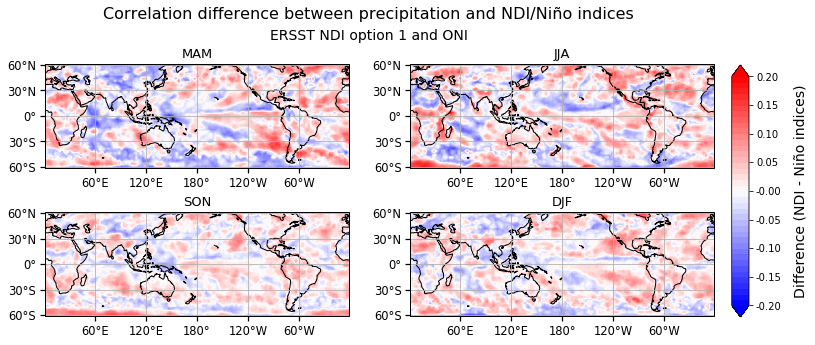

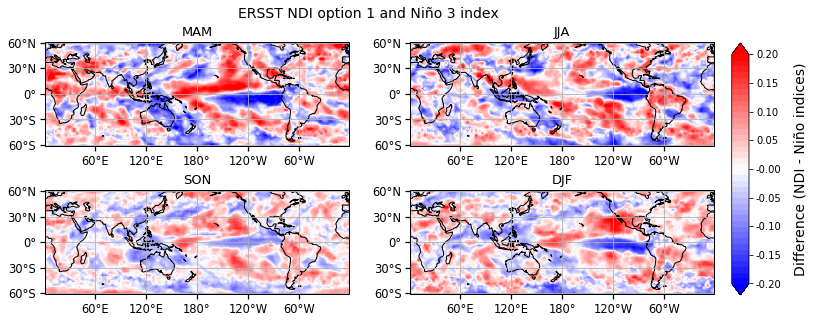

In [58]:
season_name = ['MAM','JJA','SON','DJF']
cbarticks = np.arange(-0.2,0.21,0.01)
plot_latr = GPCPll.latr(60.05,-60.05)
lon2d, lat2d = np.meshgrid(GPCPlons,GPCPlats[plot_latr[0]:plot_latr[1]])
title_header = "Correlation difference between precipitation and NDI/Niño indices"

for plots in range(2):
    fig = plt.figure(figsize=(12,5))
    if plots == 0:
        header = fig.text(0.5,0.99,title_header, ha='center', va='center',fontsize = 16)
        title = 'ERSST NDI option 1 and ONI'
        title_plot = fig.text(0.5,0.93,title, ha='center', va='center',fontsize = 14)
    else:
        title = 'ERSST NDI option 1 and Niño 3 index'
        title_plot = fig.text(0.5,0.93,title, ha='center', va='center',fontsize = 14)
    for season in range(4):
        idx_subplot = season + 1
        #must use central_lon at equator to make map cross from MC to CP/EP region
        ax = fig.add_subplot(2,2,idx_subplot,
                             projection=ccrs.PlateCarree(central_longitude=180.0)) 
    
        plt.set_cmap('bwr')
        ax.coastlines(resolution='110m')
        ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                     ylocs = [-60,-30,0,30,60], xlocs=[0,60,120,180,240,300,360])

        #remove gridline labels from top and right side of plots
        ax.xlabels_top = False
        ax.xlabels_bottom = True
        ax.ylabels_left = True
        ax.ylabels_right = False
        #Prints out latitude and longitude with proper coordinate system
        ax.set_xticks([60,120,180,-120,-60], crs = ccrs.PlateCarree())
        ax.set_yticks([-60,-30,0,30,60], crs = ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        
        ax.tick_params(axis='both',labelsize=11.5)
        ax.tick_params(width=1.25,length=5)
        
        c_diff_plot = c_diff[plots,season,plot_latr[0]:plot_latr[1],:]
        
        shading=ax.contourf(lon2d,lat2d,c_diff_plot,cbarticks,
                            transform=ccrs.PlateCarree(),extend='both')
        plt.title(season_name[season],fontsize=13)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
    cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
    cbar.set_ticks(np.arange(-0.2,0.25,0.05))
    cbarlabel = fig.text(1, 0.5, 'Difference (NDI - Niño indices)', ha='center',
                         va='center',rotation='vertical', fontsize = 14)

### 2. *Using coarse GPCP grid: 5° by 5° (latitude/longitude)*

In [59]:
'''
   Make a coarse GPCP dataset so each
   grid point represents a 5° by 5° 
   box. I want to make the correlation
   difference map smoother than the
   above plot.
   
   Do same as above with coarse GPCP
   grid using all SST datasets.
   
   Take the mean of 2 by 2 grid point
   square using full data. This reduces
   both the latitude and longitude
   grid point resolution by half.
   
   ------------- Sample -------------
   
   + = GPCP grid point
   
          Original       Coarse
            Grid          Grid
         
          + +|+ +        +   + 
          + +|+ +
          ---|---
          + +|+ +        +   +
          + +|+ +

          16 grid        4 grid
          points         points
'''

new_lat_count = int(GPCPlats.size/2)
new_lon_count = int(GPCPlons.size/2)
precipSeason_coarse = np.zeros((4,nyears_gpcp,new_lat_count,new_lon_count))

for season in range(4):
    for year in range(nyears_gpcp):
        for lat in range(0,GPCPlats.size,2):
            for lon in range(0,GPCPlons.size,2):
                if lat == 0 and lon == 0:
                    lat_store = 0
                    lon_store = 0
                else:
                    lat_store = int(lat/2)
                    lon_store = int(lon/2)
                
                mean_gpoint_box = 0
                mean_gpoint_box = np.mean(precipSeason[season,year,
                                                       lat:lat+2,lon:lon+2])             
                precipSeason_coarse[season,year,lat_store,lon_store] = mean_gpoint_box

### Create coarse latitude and longitude arrays for plotting

In [60]:
'''
   Make latitude/longitude gridpoint arrays 
   that match the coarse precipitation data 
   set for plotting.
   
   Latitude and longitude gridpoint centers 
   for coarse precipitation grid will be half 
   way between original lat/lon grid point 
   centers 1 and 2, 3 and 4, and so on.
   
   Find the grid point center for the first
   latitude and longitude point, then use
   np.arange to retrieve the rest.
'''

orig_gpoint_spacing = 2.5

GPCPlat_coarse_beg = GPCPlats[0] + orig_gpoint_spacing/2
GPCPlat_coarse_end = GPCPlats[-1] - orig_gpoint_spacing/2

GPCPlon_coarse_beg = GPCPlons[0] + orig_gpoint_spacing/2
GPCPlon_coarse_end = GPCPlons[-1] - orig_gpoint_spacing/2

#Make coarse grid point latitude/
#longitude arrays
coarse_gpoint_spacing = 5
GPCPlats_coarse = np.arange(GPCPlat_coarse_beg,GPCPlat_coarse_end+5,coarse_gpoint_spacing)
GPCPlons_coarse = np.arange(GPCPlon_coarse_beg,GPCPlon_coarse_end+5,coarse_gpoint_spacing)

#Create lat/lon object for indexing lat/lon
#bounds for plot
GPCPll_coarse = LatLon(GPCPlats_coarse[0],GPCPlats_coarse[1]-GPCPlats_coarse[0],
                       GPCPlats_coarse.size,
                       GPCPlons_coarse[0],GPCPlons_coarse[1]-GPCPlons_coarse[0],
                       GPCPlons_coarse.size)

### Correlation calculations

In [61]:
NDI_corr_1 = np.zeros((3,4,GPCPlats_coarse.size,GPCPlons_coarse.size))
ONI_corr_1 = np.zeros((3,4,GPCPlats_coarse.size,GPCPlons_coarse.size))
NINO3_corr_1 = np.zeros((3,4,GPCPlats_coarse.size,GPCPlons_coarse.size))

for sst_type in range(3):
    for season in range(4):
        for lats in range(GPCPlats_coarse.size):
            for lons in range(GPCPlons_coarse.size):
                #NDI_opts_season_trim dimensions: sst_type,ndi_opt,season,year
                NDI_corr_1[sst_type,season,lats,lons] = np.corrcoef(NDI_opts_seasons_trim[sst_type,0,season,s_idx_sst_data:],
                                                                    precipSeason_coarse[season,:,lats,lons])[0,1]
                ONI_corr_1[sst_type,season,lats,lons] = np.corrcoef(oni_seasons[sst_type,season,s_idx_sst_data:],
                                                                    precipSeason_coarse[season,:,lats,lons])[0,1]
                NINO3_corr_1[sst_type,season,lats,lons] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_sst_data:],
                                                                      precipSeason_coarse[season,:,lats,lons])[0,1]
                
#Calculate correlation difference between
#NDI option 1 and Niño indices (NDI-Niño indices)

#array indexes are: 0 = NDI vs. Nino ind. difference, 1 = sst_type,
#2 = season, 3 = lat, 4 = lon
c_diff_coarse = np.zeros((2,3,4,GPCPlats_coarse.size,GPCPlons_coarse.size))
for sst_type in range(3):
    c_diff_coarse[0,sst_type,:,:,:] = NDI_corr_1[sst_type,:,:,:] - ONI_corr_1[sst_type,:,:,:]
    c_diff_coarse[1,sst_type,:,:,:] = NDI_corr_1[sst_type,:,:,:] - NINO3_corr_1[sst_type,:,:,:]

### Plot correlation difference maps (NDI - Niño indices)

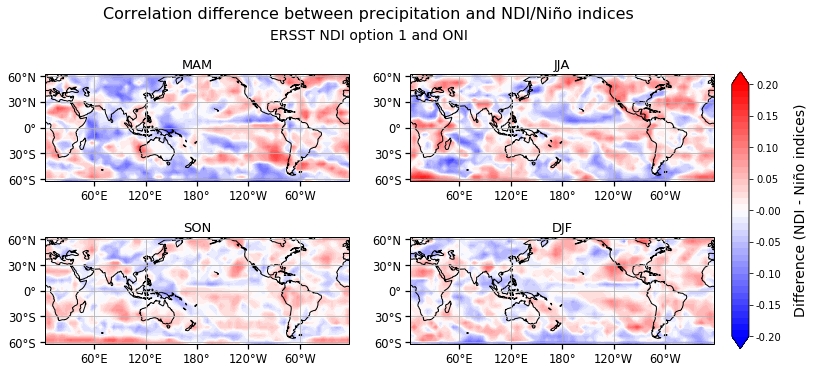

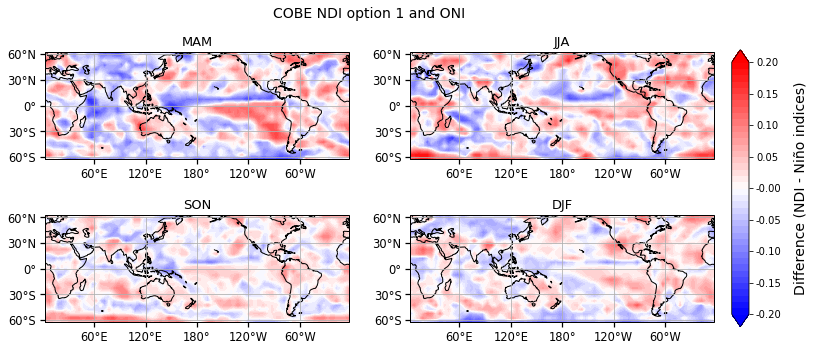

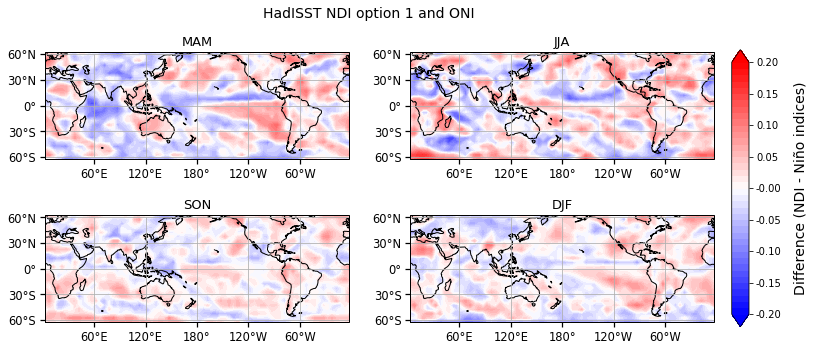

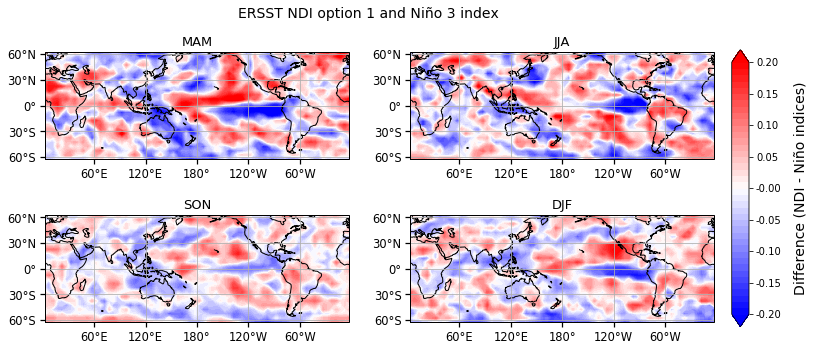

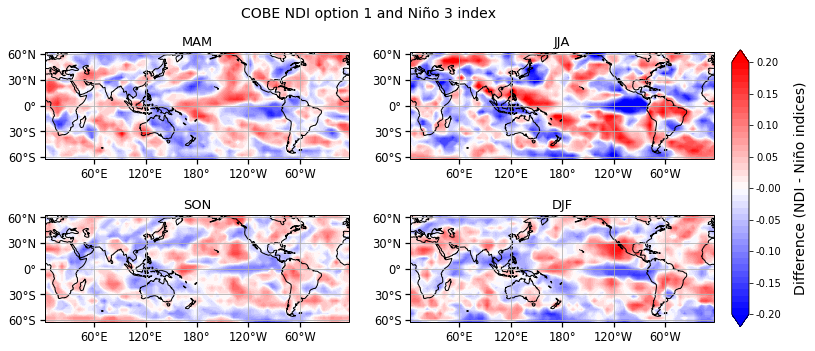

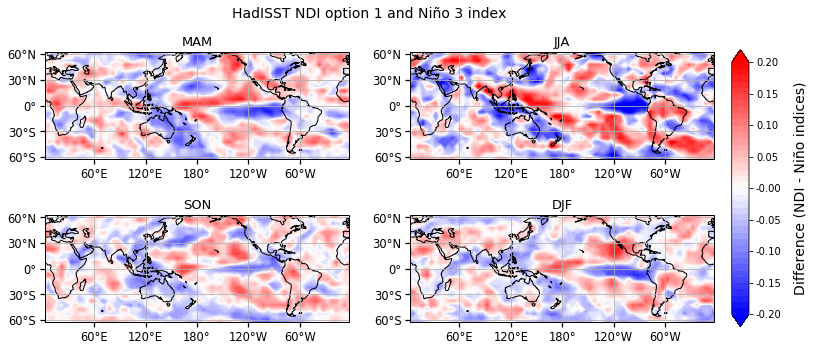

In [62]:
season_name = ['MAM','JJA','SON','DJF']
cbarticks = np.arange(-0.2,0.201,0.01)
plot_latr = GPCPll_coarse.latr(60.05,-60.05)
lon2d, lat2d = np.meshgrid(GPCPlons_coarse,GPCPlats_coarse[plot_latr[0]:plot_latr[1]])
title_header = "Correlation difference between precipitation and NDI/Niño indices"
sst_label = ['ERSST','COBE','HadISST']
for cdiff_type in range(2):
    for sst_type in range(3):
        fig = plt.figure(figsize=(12,5.5))
        #header title for all figures
        if cdiff_type == 0 and sst_type == 0:
            header = fig.text(0.5,0.995,title_header, ha='center', va='center',fontsize = 16)
        #next two if/else statements titles
        #for each figure
        if cdiff_type == 0:
            sst_label_loop = sst_label[sst_type]
            title = sst_label_loop + ' ' + 'NDI option 1 and ONI'
            title_plot = fig.text(0.5,0.94,title, ha='center', va='center',fontsize = 14)
        else:
            sst_label_loop = sst_label[sst_type]
            title = sst_label_loop + ' ' + 'NDI option 1 and Niño 3 index'
            title_plot = fig.text(0.5,0.94,title, ha='center', va='center',fontsize = 14)
        for season in range(4):
            idx_subplot = season + 1
            #must use central_lon at equator to make map cross from MC to CP/EP region
            ax = fig.add_subplot(2,2,idx_subplot,
                                 projection=ccrs.PlateCarree(central_longitude=180.0)) 
        
            plt.set_cmap('bwr')
            ax.coastlines(resolution='110m')
            ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                         ylocs = [-60,-30,0,30,60], xlocs=[0,60,120,180,240,300,360])

            #remove gridline labels from top and right side of plots
            ax.xlabels_top = False
            ax.xlabels_bottom = True
            ax.ylabels_left = True
            ax.ylabels_right = False
            #Prints out latitude and longitude with proper coordinate system
            ax.set_xticks([60,120,180,-120,-60], crs = ccrs.PlateCarree())
            ax.set_yticks([-60,-30,0,30,60], crs = ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter()
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            ax.tick_params(axis='both',labelsize=11.5)
            ax.tick_params(width=1.25,length=5)
        
            c_diff_plot = c_diff_coarse[cdiff_type,sst_type,season,plot_latr[0]:plot_latr[1],:]
        
            shading=ax.contourf(lon2d,lat2d,c_diff_plot,cbarticks,
                                transform=ccrs.PlateCarree(),extend='both')
            plt.title(season_name[season],fontsize=13)

        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
        cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
        cbar.set_ticks(np.arange(-0.2,0.25,0.05))
        cbarlabel = fig.text(1, 0.5, 'Difference (NDI - Niño indices)', ha='center',
                             va='center',rotation='vertical', fontsize = 14)

## Standard season correlations of NDI options and Niño indices <br> with GPCP tropical and Eastern Pacific PC 1

In [63]:
'''
   When NDI option 1 is compared to the Niño 3 index,
   the correlation difference noticably favors the 
   Niño 3 index in the EP region (~160°W-80°W centered
   on the equator). While this is somewhat expected 
   since the NDI has an EP box farther towards the 
   dateline (does not match the Niño 3 region), the
   coarse grid point correlations favors the Niño 3
   index for most of the Niño 3.4 region (170°W-120°W,
   5°N-5°S) for all seasons. NDI option 1 uses an EP box
   that mirrors the Niño 3.4 region.
   
   I am checking the relationship each NDI option and 
   Niño index with tropical Pacific/Eastern Pacific
   precipitation PC 1 for each standard season.
'''

dir_path_GPCP_pc1 = ENSOdir + str("GPCP\\GPCP_PC1_timeseries\\")
filename_GPCP_trop_pc1 = dir_path_GPCP_pc1 + str("trop_pc1_1979_djf2021.npy")
filename_GPCP_ep_pc1 = dir_path_GPCP_pc1 + str("east_pac_pc1_1979_djf2021.npy")

GPCP_trop_pc1 = np.load(filename_GPCP_trop_pc1)
GPCP_ep_pc1 = np.load(filename_GPCP_ep_pc1)

In [64]:
'''

   ------ Tropical PC 1 ------
   Bounds: 20°S-20°N,
           90°E-80°W
           
   --- Eastern Pacific PC 1 ---
   Bounds:-15°S-15°N,
          180° to 80°W
   
'''

syear_gpcp = 1979
syear_inds = 1910
s_idx_data = syear_gpcp - syear_inds

period_label = 'Time Period: 1979-2021'

pc_label = ['GPCP tropical PC 1','GPCP Eastern Pacific PC 1']
for pc_type in range(2):
    #label for each PC 1 test
    print('%s%s %s%s%s%s %s' % ('\033[1m','Correlations with',pc_label[pc_type],
                            '\n','        ',period_label,'\033[0m'),'\n')
    if pc_type == 0:
        GPCP_pc1 = GPCP_trop_pc1
    else:
        GPCP_pc1 = GPCP_ep_pc1
        
    for sst_type in range(3):
        print('%s %s%s%s %s' % ('----------------','\033[1m',sst_dataset[sst_type],'\033[0m','----------------'),'\n')
        c = np.zeros((8,4))
        for option in range(8):
            for season in range(4):
                if option < 6:
                    c[option,season] = np.corrcoef(NDI_opts_seasons_trim[sst_type,option,season,s_idx_data:],
                                                   GPCP_pc1[season,:])[0,1]
                elif option == 6:
                    c[option,season] = np.corrcoef(oni_seasons[sst_type,season,s_idx_data:],
                                                   GPCP_pc1[season,:])[0,1]
                else:
                    c[option,season] = np.corrcoef(nino3idx_seasons[sst_type,season,s_idx_data:],
                                                   GPCP_pc1[season,:])[0,1]
            
                #Flipping sign of correlation (for MAM and JJA),
                #since sign of PC is arbitrary
                if c[option,season] < 0:
                    c[option,season] = c[option,season]*-1
                else:
                    continue
    
        c = np.round(c,3)
        
        c_df = pd.DataFrame(c)
        c_df.index = NDI_labels
        c_df.columns = season_labels
        pd.set_option("display.colheader_justify","center")
        print(c_df,"\n")

Correlations with GPCP tropical PC 1
        Time Period: 1979-2021  

---------------- ERSST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.709  0.902  0.963  0.958
NDI Opt 2   0.700  0.887  0.962  0.961
NDI Opt 3   0.747  0.873  0.960  0.962
NDI Opt 4   0.742  0.853  0.961  0.966
NDI Opt 5   0.699  0.840  0.962  0.966
NDI Opt 6   0.631  0.936  0.940  0.939
ONI         0.661  0.905  0.944  0.953
Niño 3 idx  0.819  0.842  0.933  0.920 

---------------- COBE ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.770  0.914  0.961  0.959
NDI Opt 2   0.771  0.889  0.960  0.960
NDI Opt 3   0.804  0.894  0.958  0.961
NDI Opt 4   0.796  0.856  0.956  0.964
NDI Opt 5   0.790  0.840  0.945  0.963
NDI Opt 6   0.662  0.928  0.934  0.937
ONI         0.671  0.908  0.941  0.955
Niño 3 idx  0.792  0.846  0.936  0.919 

---------------- HadISST ---------------- 

             MAM    JJA    SON    DJF 
NDI Opt 1   0.764  0.906  0.959  0.961
NDI Opt 2   0.770 

## Plot ONI vs. Niño 3 index for each SST dataset

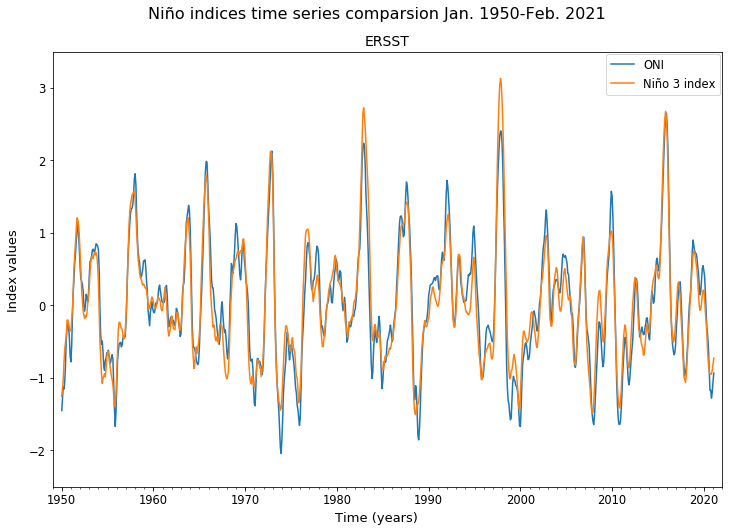

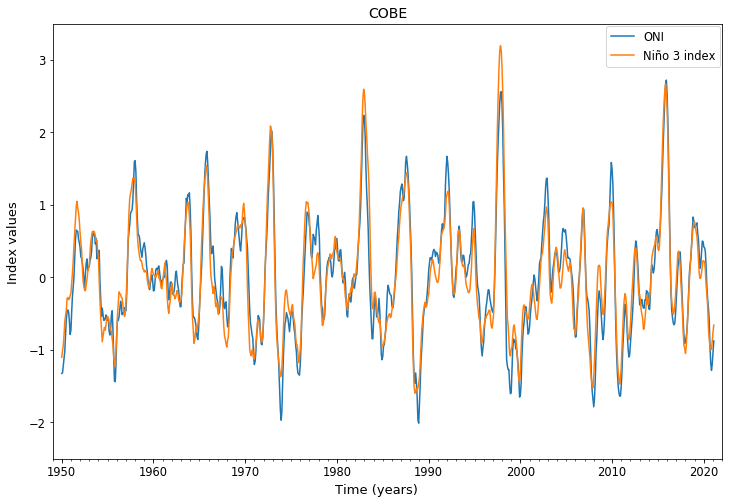

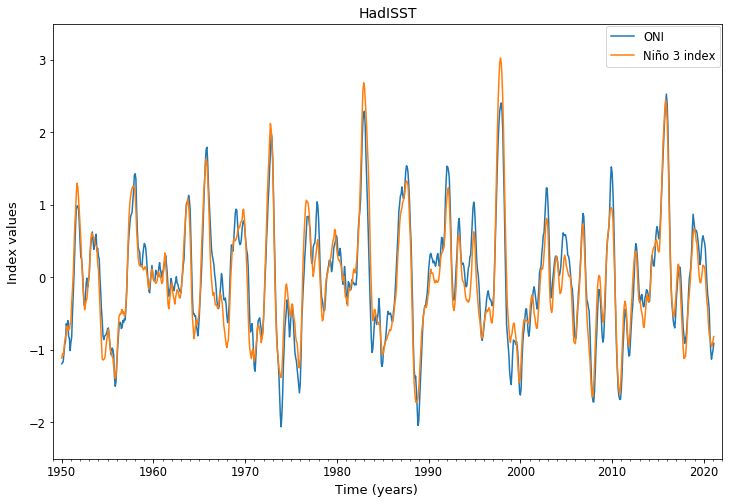

In [65]:
'''
   Test to see differences in the ONI and Niño 3 index reflection
   of EP ENSO events in terms of amplitude.
'''

#Start index for Niño indices for
#all SST datasets
start_idx_ENSO_inds= int(np.where(SSTdtime == '1910-01-01')[0])
start_ind_plot = int(np.where(SSTdtime == '1950-01-01')[0])
start_ind_data_plot = start_ind_plot - start_idx_ENSO_inds

#end index for plot, corresponds to 
#last available time-series data point for
#Niño indices
end_ind_plot = int(np.where(SSTdtime == '2021-02-01')[0]) + 1
time_axis = SSTdtime[start_ind_plot:end_ind_plot]

legend_info = ['ONI','Niño 3 index']
sst_label = ['ERSST','COBE','HadISST']
for sst_type in range(3):
    '''Plot data'''
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    
    oni_sst_type = oni[sst_type,start_ind_data_plot:]
    nino3_sst_type = nino3idx[sst_type,start_ind_data_plot:]
    
    oni_plot = ax.plot(time_axis,oni_sst_type)
    nino3_plot = ax.plot(time_axis,nino3_sst_type)
    plt.title(sst_label[sst_type],fontsize = '14')
    #set x-limit of plot with datetime
    ax.set_xlim([dt.date(1949, 1, 1), dt.date(2022, 1, 1)])
    #Set major and minor dateticks 
    ax.xaxis.set_major_locator(mdates.YearLocator(10)) 
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 

    ax.set_ylim([-2.5,3.5])
    ax.set_yticks(np.arange(-2,4,1))
    ax.tick_params(axis='both',labelsize=11.5)
    # Set x and y labels
    fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 13)
    fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 13)
    #header label for all figures
    if sst_type == 0:
        fig.text(0.5,0.945,'Niño indices time series comparsion Jan. 1950-Feb. 2021',ha='center',
                va='center',fontsize=16)
    #legend
    fig.legend([oni_plot,nino3_plot], labels=legend_info,
               bbox_to_anchor = (0.84,0.84),fontsize = 11.5)